In [1]:
# Load Libraries
library(Seurat)
library(SCopeLoomR)
library(SCENIC)
library(AUCell)
library(KernSmooth)
library(plotly)
library(dplyr)
library(data.table)
library(ggplot2)
library(ComplexHeatmap)

# Set Working Directory
setwd("../")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘SCopeLoomR’


The following object is masked from ‘package:base’:

    flush



Attaching package: ‘AUCell’


The following object is masked from ‘package:SCENIC’:

    plotEmb_rgb


KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ggplot2


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dp

# Export data as .loom file

In [3]:
# Load Data
data <- readRDS("GBMProject/GBMOrganoid/Checkpoints/1_DataPreprocessing.rds")

##### Prepare .loom file for pySCENIC analysis#####
build_loom(file.name = "GBMProject/GBMOrganoid/Checkpoints/scrnaseq.loom",
           dgem = data[["RNA"]]$counts,
           title = "Organoids")#,
           #default.embedding = data@reductions$umap@cell.embeddings,
           #default.embedding.name = "umap")

#loom <- open_loom("GBMProject/GBMOrganoid/SCENIC/input.loom", mode = "r+")

#add_col_attr(loom = loom, key = "genotype", value = data$HTO_maxID)
#add_col_attr(loom = loom, key = "maincelltype", value = data$celltype)
#add_col_attr(loom = loom, key = "subcelltype", value = data$celltype2)
#add_col_attr(loom = loom, key = "cluster", value = data$seurat_clusters)

close_loom(loom)

[1] "Adding global attributes..."
[1] "Adding matrix..."
  |======================================================================| 100%[1] "Adding column attributes..."
[1] "Adding default metrics nUMI..."
[1] "Adding default metrics nGene..."


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“No default embedding set for the loom. You'll not be able to visualize it in SCope.”


[1] "Adding row attributes..."
[1] "Adding columns graphs..."
[1] "Adding row graphs..."
[1] "Adding layers..."


# pySCENIC Workflow

#Run in terminal
conda activate pyscenic

#Run the GRNBoost2 network inference algorithm / TFs from aertslab/pySCENIC/resources GITHUB

pyscenic grn --output output/adj_organoid.tsv --method grnboost2 --seed 123 --num_workers 15 input.loom allTFs_hg38.txt


#Candidate regulon generation and regulon prediction

pyscenic ctx output/adj_organoid.tsv hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.scores.feather hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.scores.feather hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather --output output/regulons_organoid.csv --mode "dask_multiprocessing" --annotations_fname motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl --num_workers 20 --expression_mtx_fname input.loom


#Cellular enrichment

pyscenic aucell input.loom output/regulons_organoid.csv --output output_organoid.loom --num_workers 20


#Calculate Pearson Correlations

pyscenic add_cor --output output/pearsoncorr_organoid.csv output/adj_organoid.tsv input.loom 

# Import SCENIC Results

In [2]:
#Load Data
data <- readRDS("GBMProject/GBMOrganoid/Checkpoints/1_DataPreprocessing.rds")
loom <- open_loom("GBMProject/GBMOrganoid/SCENIC/output_organoid.loom", mode = "r+")

# Read information from loom file:
exprMat <- get_dgem(loom)
exprMat_log <- log2(exprMat+1) # Better if it is logged/normalized
regulons_incidMat <- get_regulons(loom, column.attr.name='Regulons')
regulons <- regulonsToGeneLists(regulons_incidMat)
regulonAUC <- get_regulons_AUC(loom, column.attr.name='RegulonsAUC')
regulonAucThresholds <- get_regulon_thresholds(loom)
embeddings <- get_embeddings(loom)
genotype <- get_cell_annotation(loom,annotations.columns = "genotype")
celltype <- get_cell_annotation(loom,annotations.columns = "maincelltype")
celltype2 <- get_cell_annotation(loom,annotations.columns = "subcelltype")
cluster <- get_cell_annotation(loom,annotations.columns = "cluster")

close_loom(loom)

In [3]:
#Load into Seurat Object
AUCmat <- AUCell::getAUC(regulonAUC)
data[["AUC"]] <- CreateAssayObject(counts = AUCmat)
DefaultAssay(data) <- "AUC"
data <- NormalizeData(data, assay = "AUC")
data <- ScaleData(data, assay = "AUC")
data <- FindVariableFeatures(data, assay = "AUC", nfeatures = 200)

data <- RunPCA(data, features = rownames(data))
data <- FindNeighbors(data, dims = 1:20)
data <- FindClusters(data, resolution = 0.5, cluster.name="GRN_clusters")
data <- RunUMAP(data, dims = 1:20, reduction.name = "umap_grn")

data

Centering and scaling data matrix

PC_ 1 
Positive:  SOX11(+), NR2F1(+), TFDP2(+), PAX6(+), ZBTB20(+), PBX1(+), RFX3(+), POU3F3(+), RFX4(+), POU2F1(+) 
	   VEZF1(+), ZNF37A(+), KLF7(+), NFIA(+), POU3F4(+), ETV1(+), ZBTB44(+), SREBF2(+), SOX1(+), BACH2(+) 
	   SOX21(+), ONECUT2(+), SOX3(+), SOX2(+), POU3F2(+), ELK4(+), LHX1(+), ARX(+), NR2F2(+), FEZF1(+) 
Negative:  JUNB(+), CEBPB(+), IRF9(+), XBP1(+), IRF7(+), CEBPD(+), NR2F6(+), IRF8(+), CEBPA(+), RUNX1(+) 
	   KLF6(+), ZNF580(+), IRF1(+), SPI1(+), ATF3(+), NR1I3(+), YY1(+), FOS(+), JUND(+), CREB3(+) 
	   KLF5(+), ATF4(+), FOXA3(+), GATA1(+), TAL1(+), CEBPG(+), PITX1(+), CHURC1(+), ELK3(+), CDX2(+) 
PC_ 2 
Positive:  ZNF431(+), ZBTB7A(+), EGR1(+), ETS1(+), ARID3A(+), KLF10(+), IKZF2(+), ZNF148(+), GATA6(+), FOXO3(+) 
	   SP3(+), ZFX(+), STAT2(+), ZSCAN30(+), FOSL2(+), FLI1(+), THRB(+), ETV3(+), ERG(+), PLAGL1(+) 
	   KLF4(+), STAT3(+), PURA(+), ETS2(+), SMAD5(+), TFAP2A(+), TWIST1(+), SP1(+), RXRB(+), ZFP42(+) 
Negative:  YBX1(+), ILF

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5073
Number of edges: 177417

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8690
Number of communities: 11
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:19:06 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

14:19:06 Read 5073 rows and found 20 numeric columns

14:19:06 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

14:19:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:19:07 Writing NN index file to t

An object of class Seurat 
25814 features across 5073 samples within 3 assays 
Active assay: AUC (411 features, 200 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: RNA, HTO
 3 dimensional reductions calculated: pca, umap, umap_grn

# SAVE CHECKPOINT

In [4]:
saveRDS(data, file = "GBMProject/GBMOrganoid/Checkpoints/2_iGRNs.rds")

# Analysis

[1] 411

[1] "ALX1(+)"   "ARID3A(+)" "ARNT(+)"   "ARX(+)"    "ATF3(+)"   "ATF4(+)"

AUC for 411 regulons (rows) and 5073 cells (columns).

Top-left corner of the AUC matrix:
           cells
regulons    AAACCCAAGAATTGTG-1 AAACCCAAGAGTACCG-1 AAACCCAAGCAATTCC-1
  ALX1(+)           0.00000000       0.0006834051         0.00000000
  ARID3A(+)         0.03137956       0.0137433714         0.03221919
  ARNT(+)           0.04094488       0.0262092238         0.01602925
  ARX(+)            0.12401575       0.2720009264         0.26285317
  ATF3(+)           0.04745585       0.0414177340         0.03318805
  ATF4(+)           0.02725685       0.0505628258         0.04875513
           cells
regulons    AAACCCACACACGGTC-1 AAACCCACAGGCATGA-1
  ALX1(+)          0.001247957        0.027856188
  ARID3A(+)        0.018491885        0.037035996
  ARNT(+)          0.000000000        0.004049494
  ARX(+)           0.120588235        0.348193608
  ATF3(+)          0.029962377        0.041391008
  ATF4(+)          0.043673062        0.045902185

[1] 411

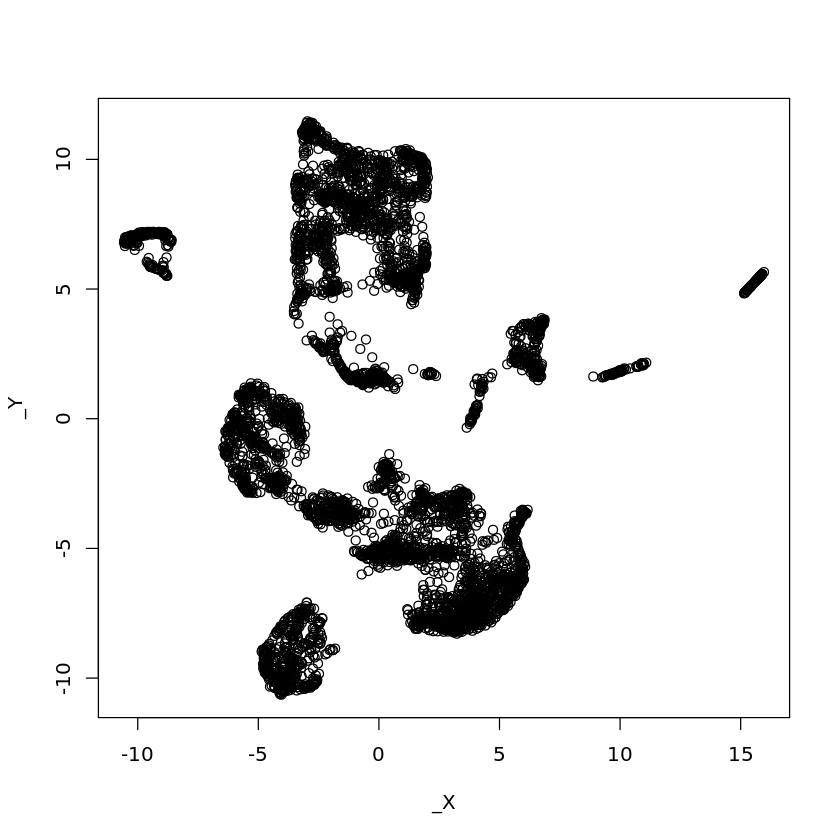

In [5]:
### To check whether it was read properly:
length(regulons);  head(names(regulons))
regulonAUC
length(regulonAucThresholds)
plot(embeddings$`umap`)

## Main Cell Type

In [6]:
# To start from cell type annotations
head(celltype)

maincelltype 
AAACCCAAGAATTGTG-1 Neuronal     
AAACCCAAGAGTACCG-1 Proliferating
AAACCCAAGCAATTCC-1 Radial Glia  
AAACCCACACACGGTC-1 Radial Glia  
AAACCCACAGGCATGA-1 Radial Glia  
AAACCCACATTGAGCT-1 Radial Glia

In [7]:
selectedResolution <- "maincelltype" # select resolution

# Split the cells by cluster:
cellsPerCelltype <- split(rownames(celltype), celltype[,selectedResolution]) 
regulonAUC <- regulonAUC[onlyNonDuplicatedExtended(rownames(regulonAUC)),]

# Calculate average expression:
regulonActivity_byCellType <- sapply(cellsPerCelltype,
                                     function(cells) rowMeans(getAUC(regulonAUC)[,cells]))
# Scale expression:
regulonActivity_byCellType_Scaled <- t(scale(t(regulonActivity_byCellType), center = T, scale=T))
write.csv(regulonActivity_byCellType_Scaled, file = "GBMProject/GBMOrganoid/SCENIC/Celltype_RegulonActivity.csv")                               

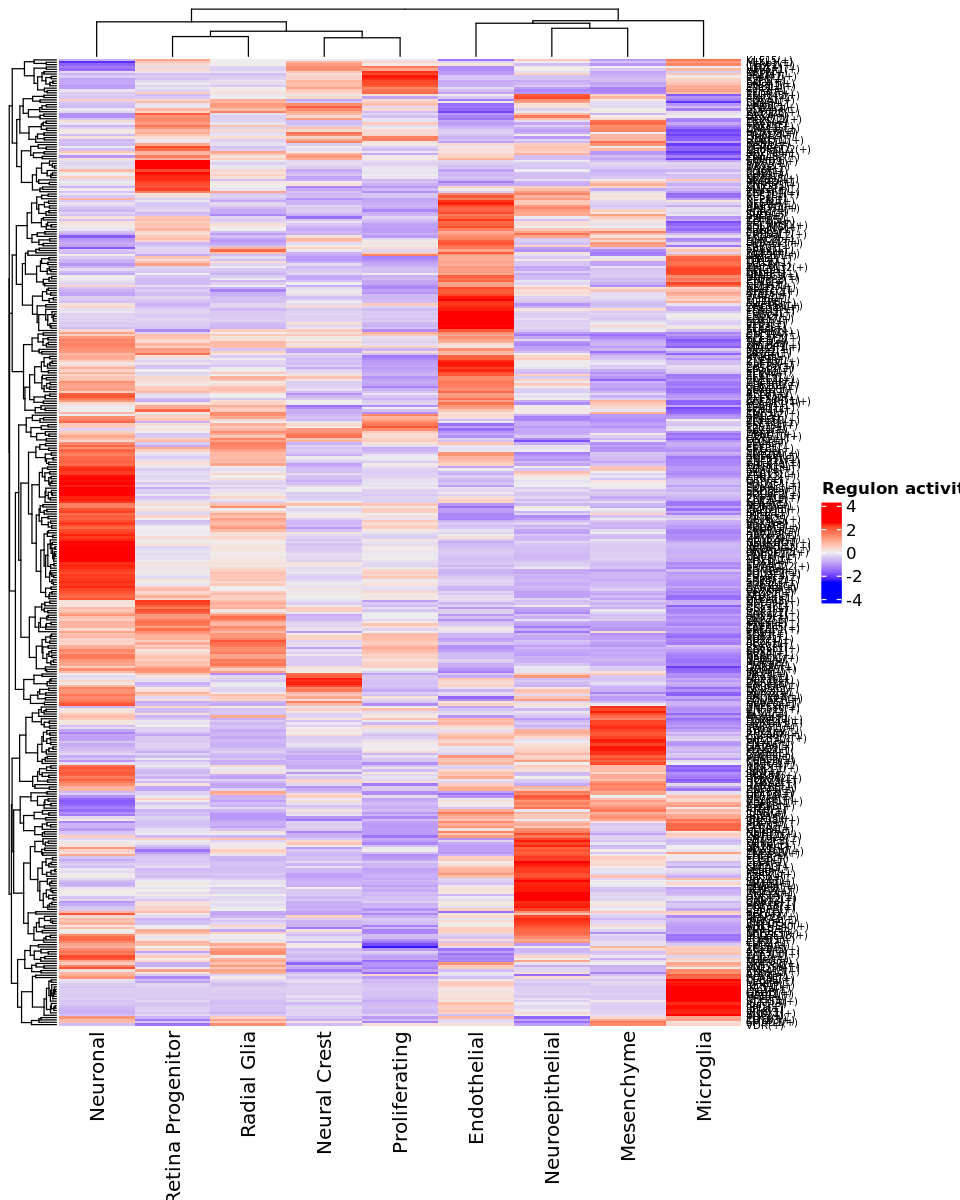

In [8]:
# plot:
options(repr.plot.width=8, repr.plot.height=10) # To set the figure size in Jupyter
hm <- draw(ComplexHeatmap::Heatmap(regulonActivity_byCellType_Scaled, name="Regulon activity",
                       row_names_gp=grid::gpar(fontsize=6))) # row font size
regulonOrder <- rownames(regulonActivity_byCellType_Scaled)[row_order(hm)] # to save the clustered regulons for later
write.csv(regulonOrder, file = "GBMProject/GBMOrganoid/SCENIC/Celltype_RegulonOrder.csv")    

In [9]:
topRegulators <- reshape2::melt(regulonActivity_byCellType_Scaled)
colnames(topRegulators) <- c("Regulon", "CellType", "RelativeActivity")
topRegulators$CellType <- factor(as.character(topRegulators$CellType))
topRegulators <- topRegulators[which(topRegulators$RelativeActivity>0),]
dim(topRegulators)

[1] 1453    3

In [10]:
rss <- calcRSS(AUC=getAUC(regulonAUC), cellAnnotation=celltype[colnames(regulonAUC), selectedResolution])
write.csv(rss, file = "GBMProject/GBMOrganoid/SCENIC/Celltype_RegulonSpecificityScore.csv")    

Loading required package: BiocParallel



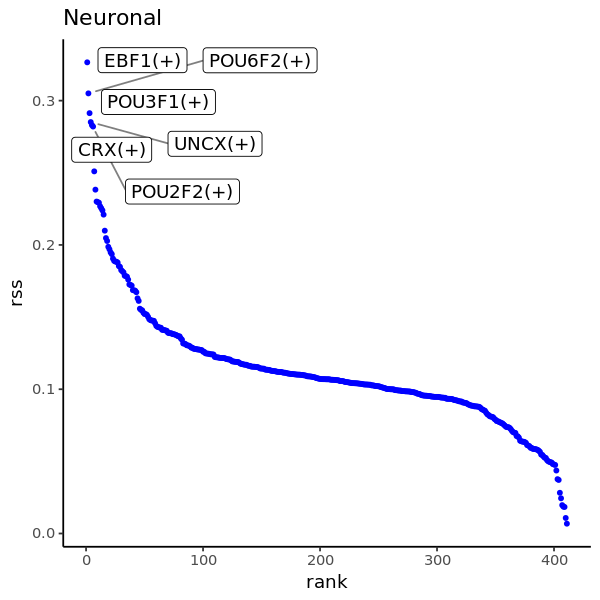

In [11]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "Neuronal", n = 6) # cluster ID

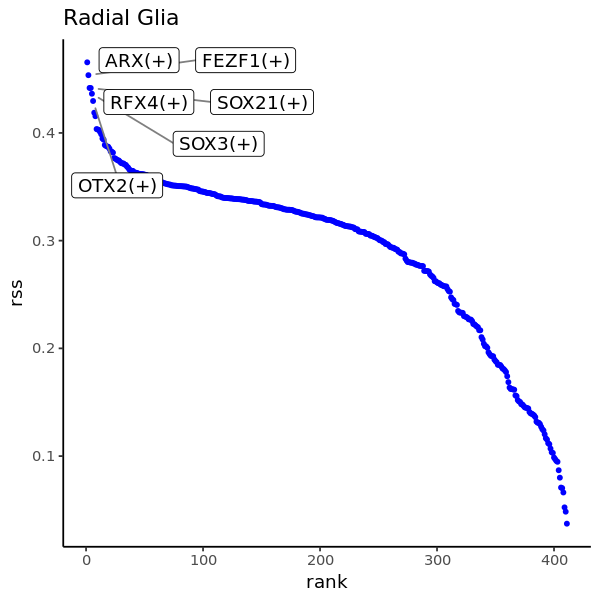

In [12]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "Radial Glia", n = 6) # cluster ID

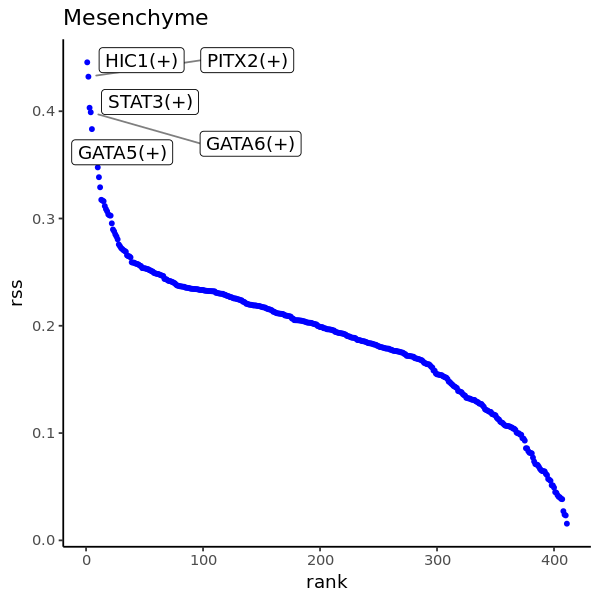

In [13]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "Mesenchyme") # cluster ID

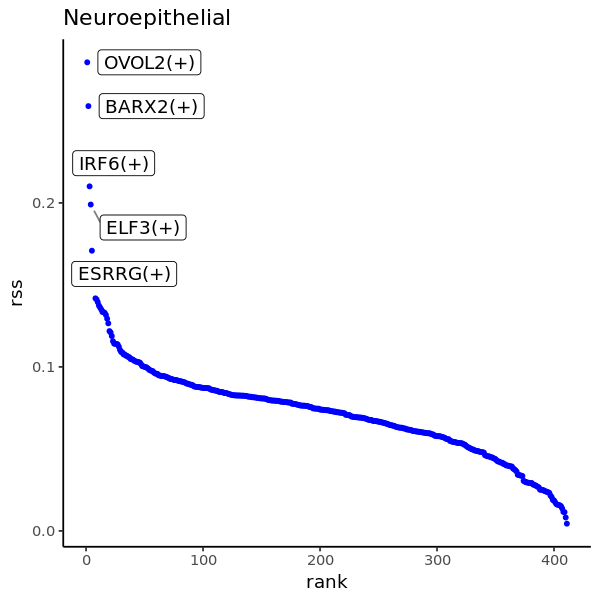

In [14]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "Neuroepithelial") # cluster ID

## Sub-Celltype

In [15]:
# To start from cell type annotations
head(celltype2)

subcelltype  
AAACCCAAGAATTGTG-1 Neuronal     
AAACCCAAGAGTACCG-1 Proliferating
AAACCCAAGCAATTCC-1 RGC-2        
AAACCCACACACGGTC-1 RGC-3        
AAACCCACAGGCATGA-1 RGC-2        
AAACCCACATTGAGCT-1 RGC-1

In [16]:
selectedResolution <- "subcelltype" # select resolution

# Split the cells by cluster:
cellsPerCelltype <- split(rownames(celltype2), celltype2[,selectedResolution]) 
regulonAUC <- regulonAUC[onlyNonDuplicatedExtended(rownames(regulonAUC)),]

# Calculate average expression:
regulonActivity_byCellType <- sapply(cellsPerCelltype,
                                     function(cells) rowMeans(getAUC(regulonAUC)[,cells]))
# Scale expression:
regulonActivity_byCellType_Scaled <- t(scale(t(regulonActivity_byCellType), center = T, scale=T))
write.csv(regulonActivity_byCellType_Scaled, file = "GBMProject/GBMOrganoid/SCENIC/SubCelltype_RegulonActivity.csv")                               

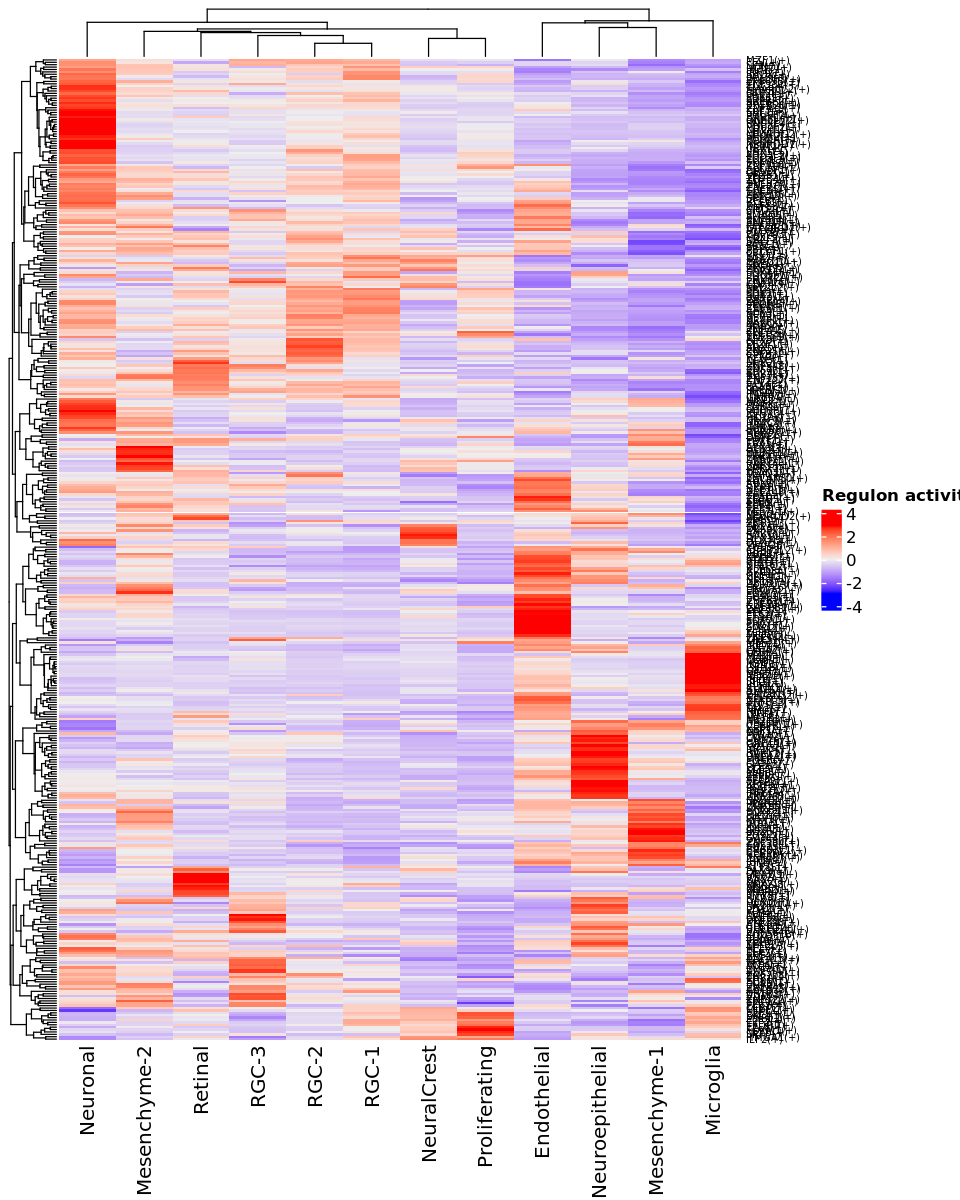

In [17]:
# plot:
options(repr.plot.width=8, repr.plot.height=10) # To set the figure size in Jupyter
hm <- draw(ComplexHeatmap::Heatmap(regulonActivity_byCellType_Scaled, name="Regulon activity",
                       row_names_gp=grid::gpar(fontsize=6))) # row font size
regulonOrder <- rownames(regulonActivity_byCellType_Scaled)[row_order(hm)] # to save the clustered regulons for later
write.csv(regulonOrder, file = "GBMProject/GBMOrganoid/SCENIC/SubCelltype_RegulonOrder.csv")    

In [18]:
topRegulators <- reshape2::melt(regulonActivity_byCellType_Scaled)
colnames(topRegulators) <- c("Regulon", "CellType", "RelativeActivity")
topRegulators$CellType <- factor(as.character(topRegulators$CellType))
topRegulators <- topRegulators[which(topRegulators$RelativeActivity>0),]
dim(topRegulators)

[1] 1975    3

In [19]:
rss <- calcRSS(AUC=getAUC(regulonAUC), cellAnnotation=celltype2[colnames(regulonAUC), selectedResolution])
write.csv(rss, file = "GBMProject/GBMOrganoid/SCENIC/SubCelltype_RegulonSpecificityScore.csv")    

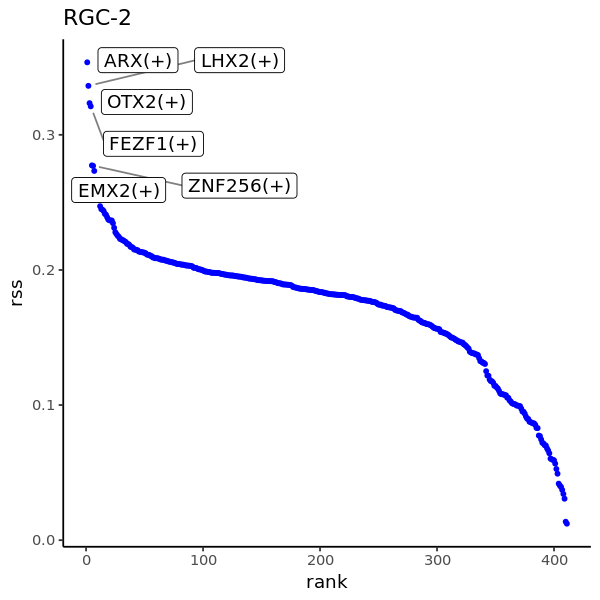

In [20]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "RGC-2", n = 6) # cluster ID

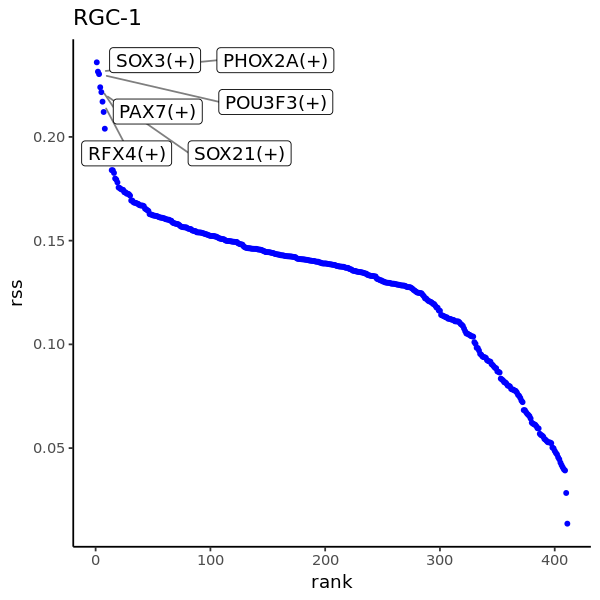

In [21]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "RGC-1", n = 6) # cluster ID

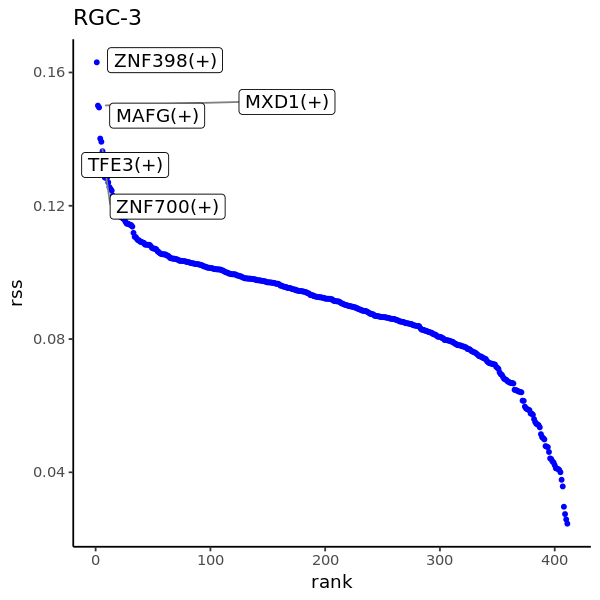

In [22]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "RGC-3") # cluster ID

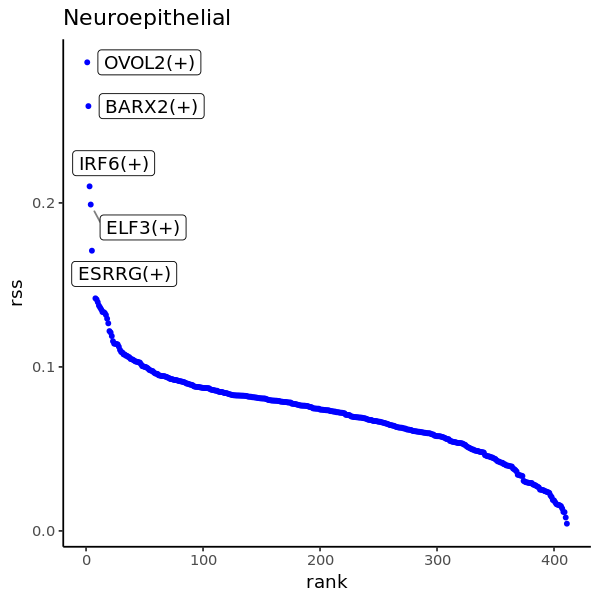

In [23]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss, setName = "Neuroepithelial") # cluster ID

## Genotype

In [24]:
# To start from clusters/cell types from Scanpy: 
head(genotype)

genotype
AAACCCAAGAATTGTG-1 PRO     
AAACCCAAGAGTACCG-1 MES     
AAACCCAAGCAATTCC-1 MES     
AAACCCACACACGGTC-1 PRO     
AAACCCACAGGCATGA-1 PRO     
AAACCCACATTGAGCT-1 WT

In [25]:
selectedResolution <- "genotype" # select resolution

# Split the cells by cluster:
cellsPerGenotype <- split(rownames(genotype), genotype[,selectedResolution]) 
regulonAUC <- regulonAUC[onlyNonDuplicatedExtended(rownames(regulonAUC)),]

# Calculate average expression:
regulonActivity_byGenotype <- sapply(cellsPerGenotype, function(cells) rowMeans(getAUC(regulonAUC)[,cells]))
write.csv(regulonActivity_byGenotype, file = "GBMProject/GBMOrganoid/SCENIC/Genotype_RegulonActivity_avg.csv")  
                                     
# Scale expression:
regulonActivity_byGenotype_Scaled <- t(scale(t(regulonActivity_byGenotype), center = T, scale=T))
write.csv(regulonActivity_byGenotype_Scaled, file = "GBMProject/GBMOrganoid/SCENIC/Genotype_RegulonActivity_scaled.csv")   

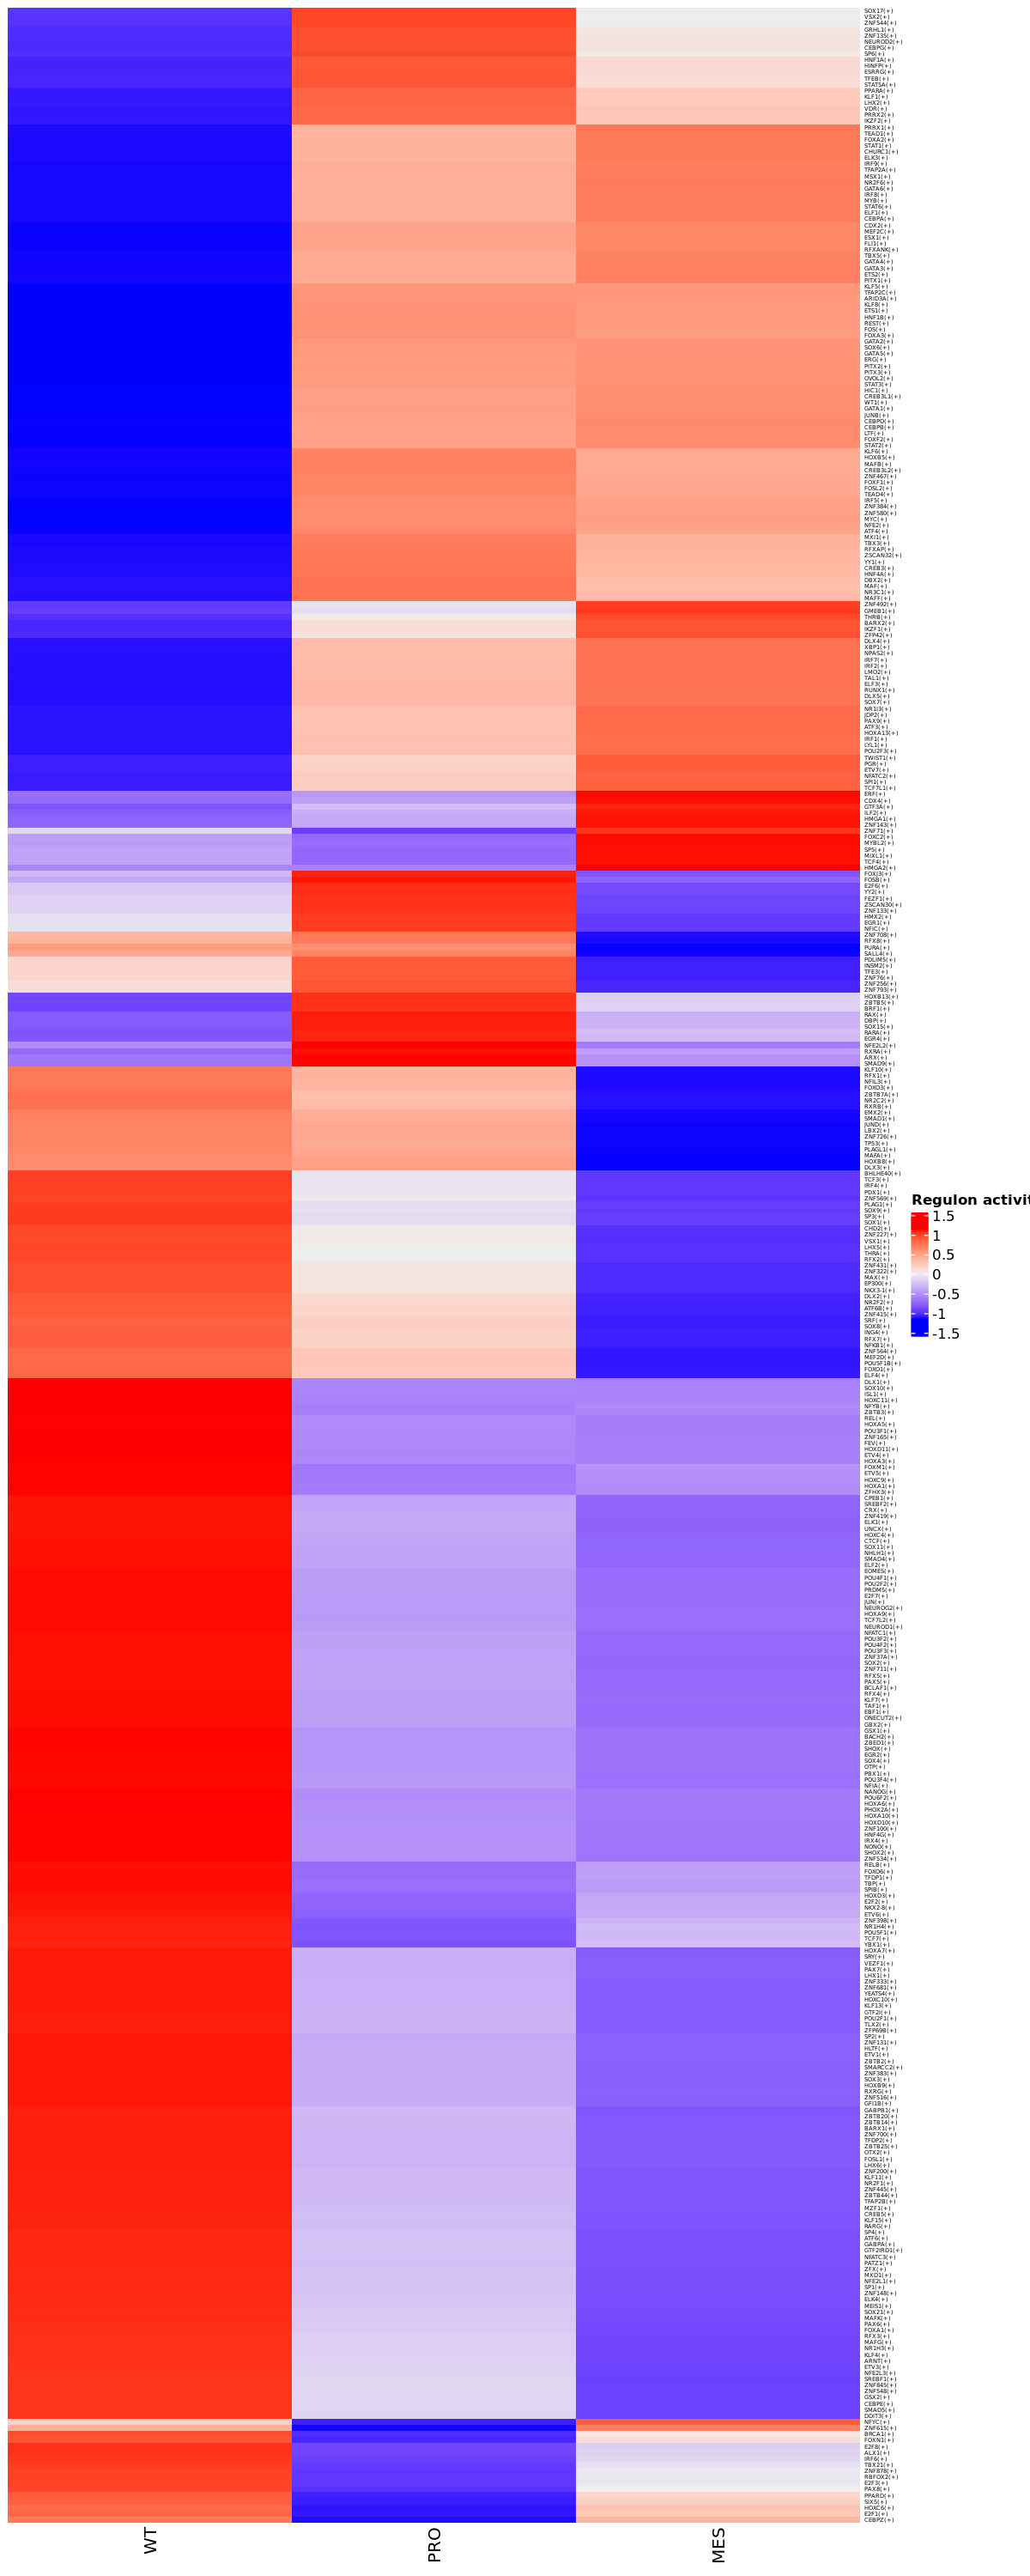

In [55]:
# plot:
options(repr.plot.width=10, repr.plot.height=25) # To set the figure size in Jupyter

hm <- draw(ComplexHeatmap::Heatmap(regulonActivity_byGenotype_Scaled, name="Regulon activity",show_column_dend = FALSE, show_row_dend = FALSE,
                       row_names_gp=grid::gpar(fontsize=4)))

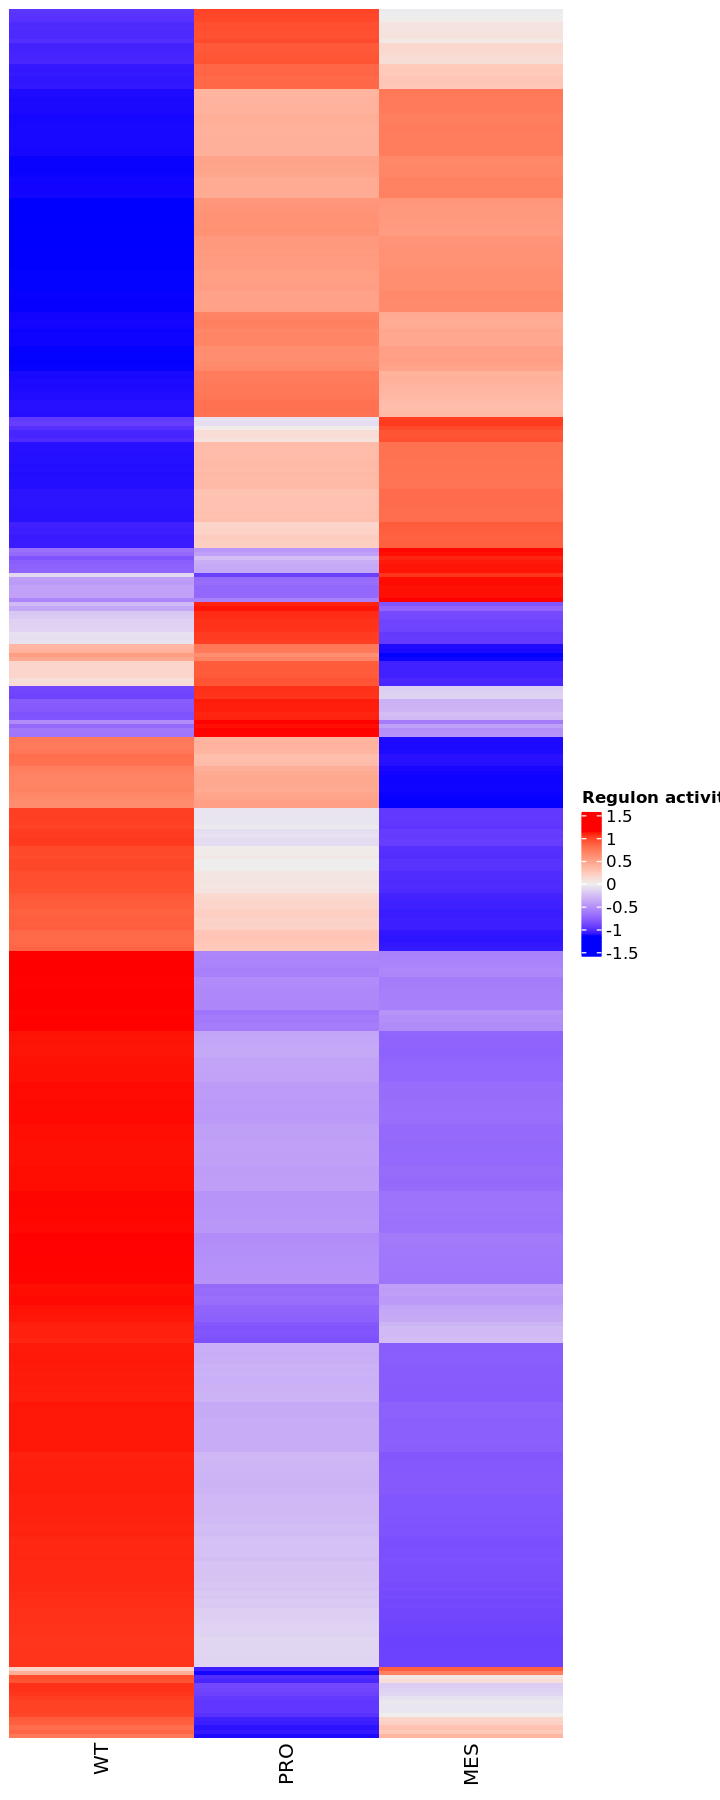

In [26]:
# plot:
options(repr.plot.width=6, repr.plot.height=15) # To set the figure size in Jupyter

hm <- draw(ComplexHeatmap::Heatmap(regulonActivity_byGenotype_Scaled, name="Regulon activity",show_column_dend = FALSE, show_row_dend = FALSE,
                       row_names_gp=grid::gpar(fontsize=0)))

regulonOrder <- rownames(regulonActivity_byGenotype_Scaled)[row_order(hm)] # to save the clustered regulons for later
write.csv(regulonOrder, file = "GBMProject/GBMOrganoid/SCENIC/Genotype_RegulonOrder.csv")  

In [27]:
rss2 <- calcRSS(AUC=getAUC(regulonAUC), cellAnnotation=genotype[colnames(regulonAUC), selectedResolution])
write.csv(rss2, file = "GBMProject/GBMOrganoid/SCENIC/Genotype_RegulonSpecificityScore.csv") 

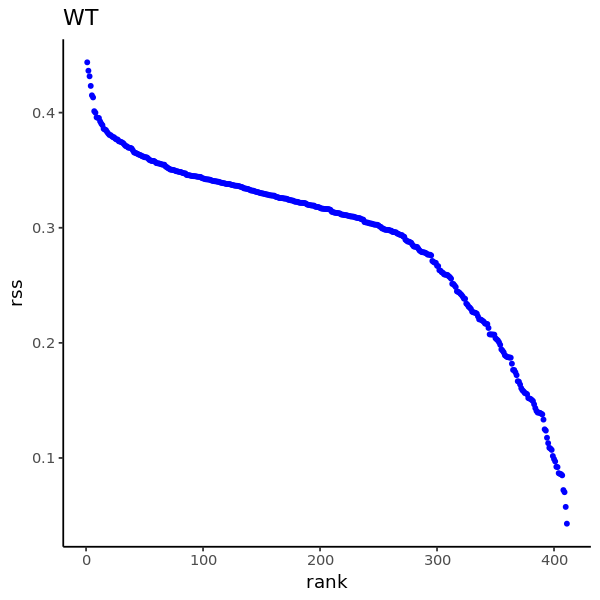

In [28]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss2, setName = "WT", n=0) # cluster ID

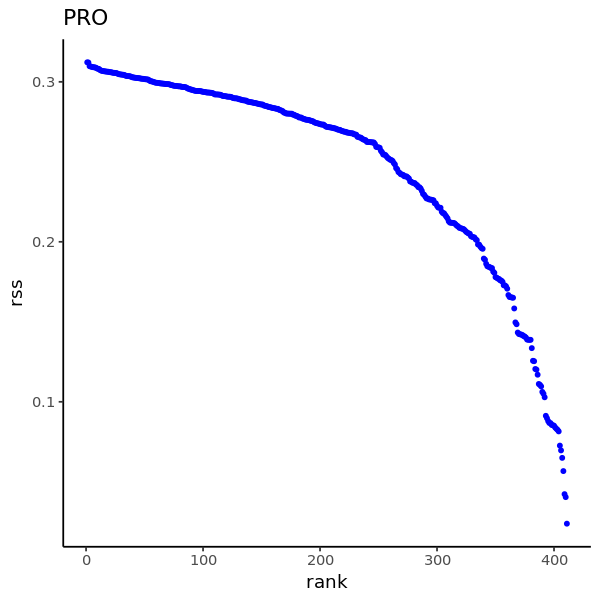

In [29]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss2, setName = "PRO", n=0) # cluster ID

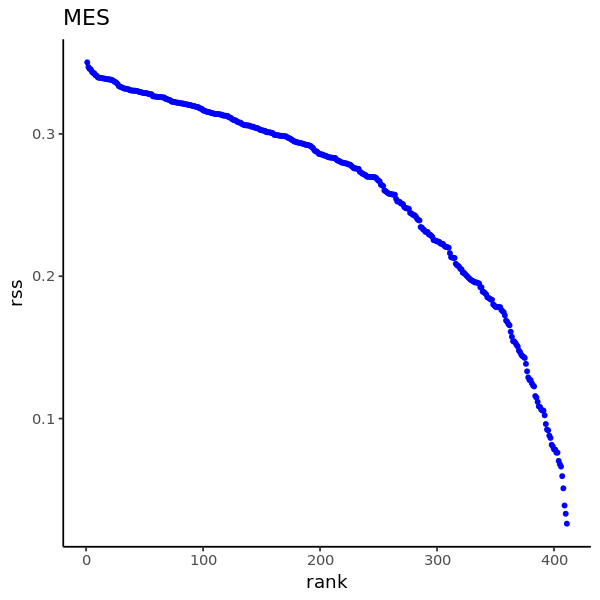

In [30]:
options(repr.plot.width=5, repr.plot.height=5) # To set the figure size in Jupyter
plotRSS_oneSet(rss2, setName = "MES", n=0) # cluster ID

## Seurat Obj

In [57]:
head(VariableFeatures(data), 50)

[1] "PITX2(+)"   "NKX2-8(+)"  "EBF1(+)"    "HIC1(+)"    "NFE2L2(+)" 
 [6] "POU3F1(+)"  "SOX6(+)"    "PRRX1(+)"   "ZNF548(+)"  "SOX9(+)"   
[11] "POU4F1(+)"  "ESX1(+)"    "OTX2(+)"    "HOXA7(+)"   "NEUROD2(+)"
[16] "LHX2(+)"    "OTP(+)"     "ZNF711(+)"  "ZNF256(+)"  "IRF6(+)"   
[21] "ZNF227(+)"  "ZNF135(+)"  "PAX9(+)"    "GTF3A(+)"   "UNCX(+)"   
[26] "BRF1(+)"    "POU2F2(+)"  "HOXA3(+)"   "SOX21(+)"   "FOXC2(+)"  
[31] "HOXB5(+)"   "TBP(+)"     "SMARCC2(+)" "NPAS2(+)"   "LMO2(+)"   
[36] "VSX1(+)"    "HLTF(+)"    "NFYC(+)"    "ARX(+)"     "ZNF415(+)" 
[41] "REST(+)"    "ELF2(+)"    "CRX(+)"     "SRY(+)"     "VSX2(+)"   
[46] "ZNF845(+)"  "RAX(+)"     "PPARD(+)"   "SIX5(+)"    "STAT3(+)"

Warning message:
“ggrepel: 38 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


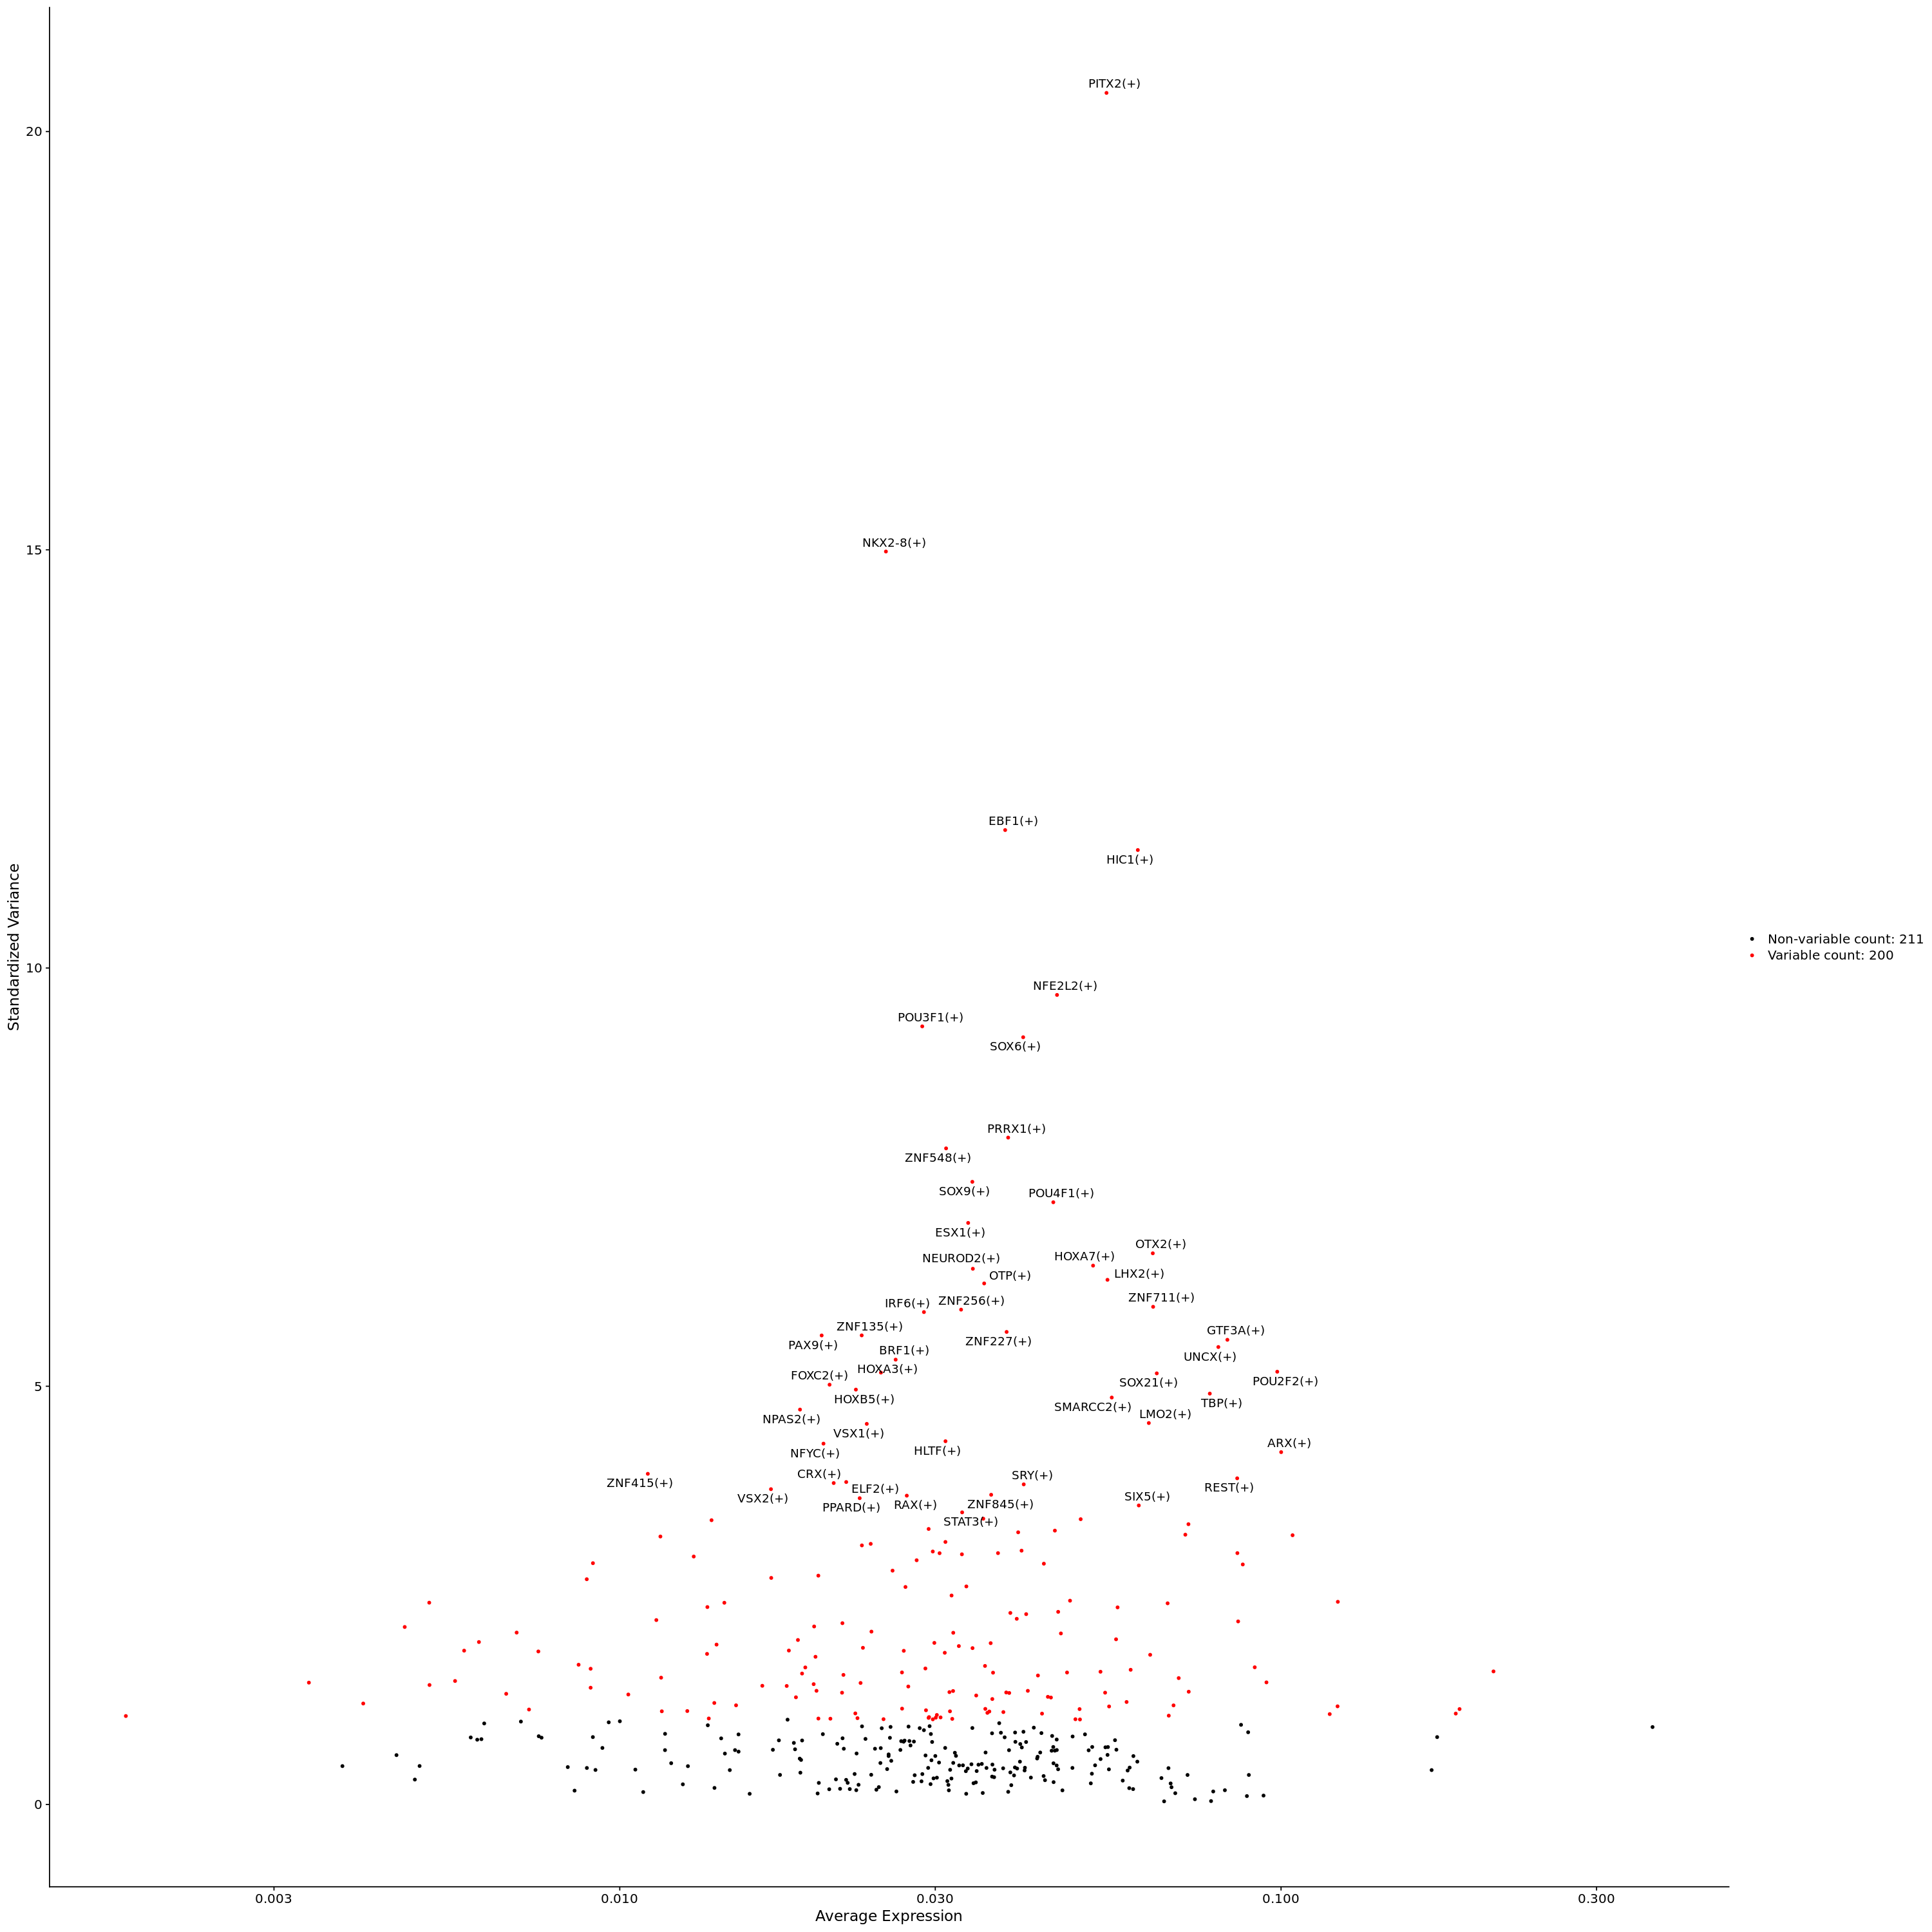

In [58]:
options(repr.plot.width=25, repr.plot.height=25) # To set the figure size in Jupyter

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(data), 50)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(data)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE, xnudge=0, ynudge=0)
plot2

Warning message:
“ggrepel: 18 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


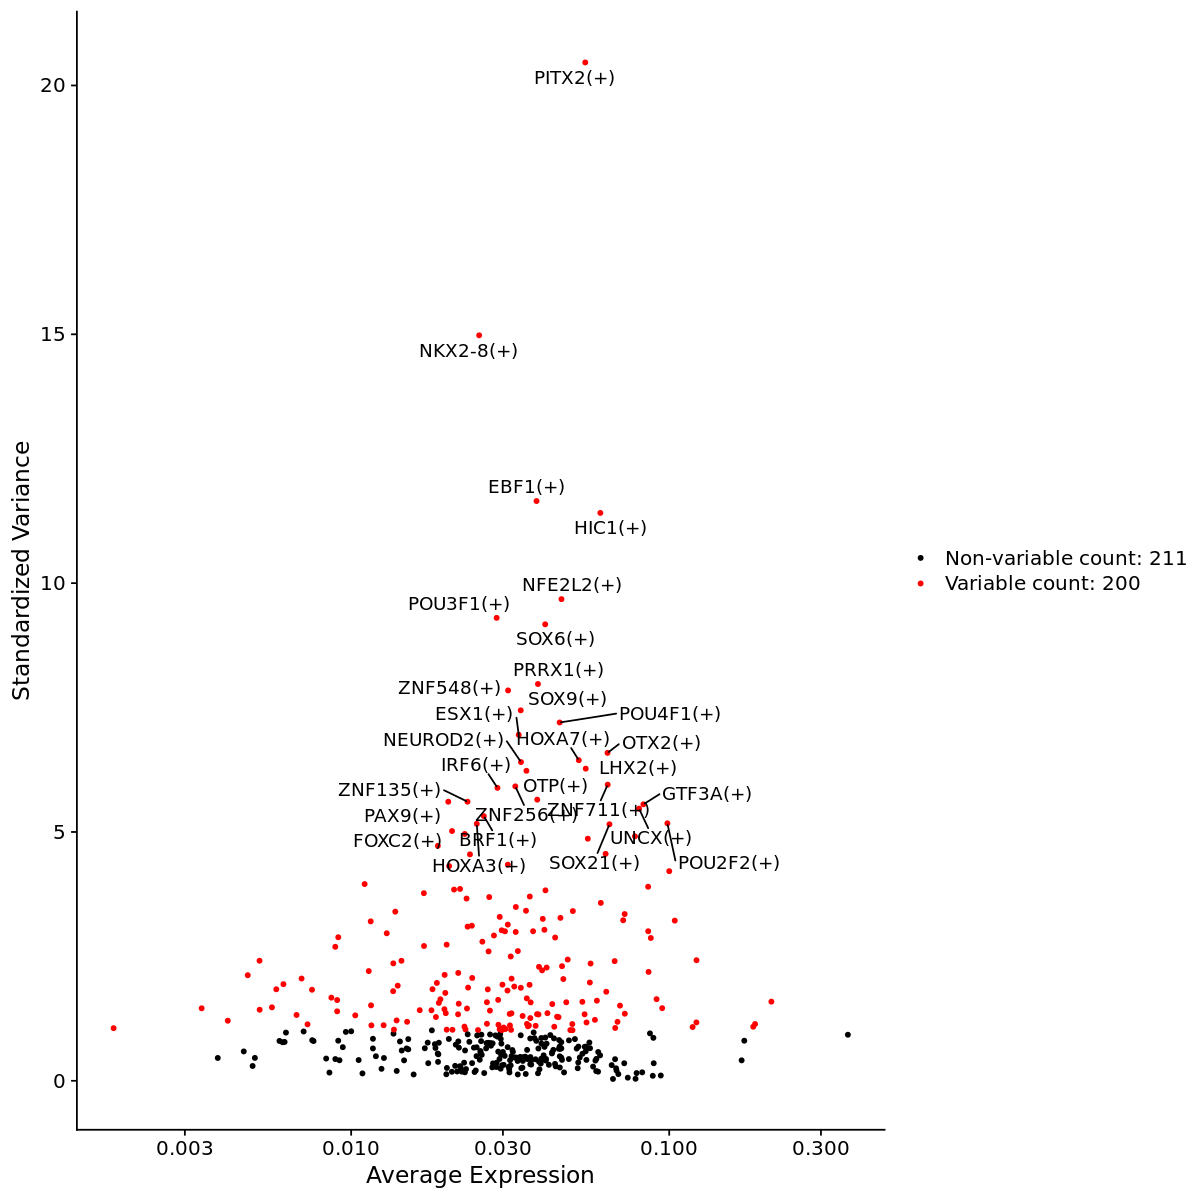

In [33]:
options(repr.plot.width=10, repr.plot.height=10) # To set the figure size in Jupyter
plot2

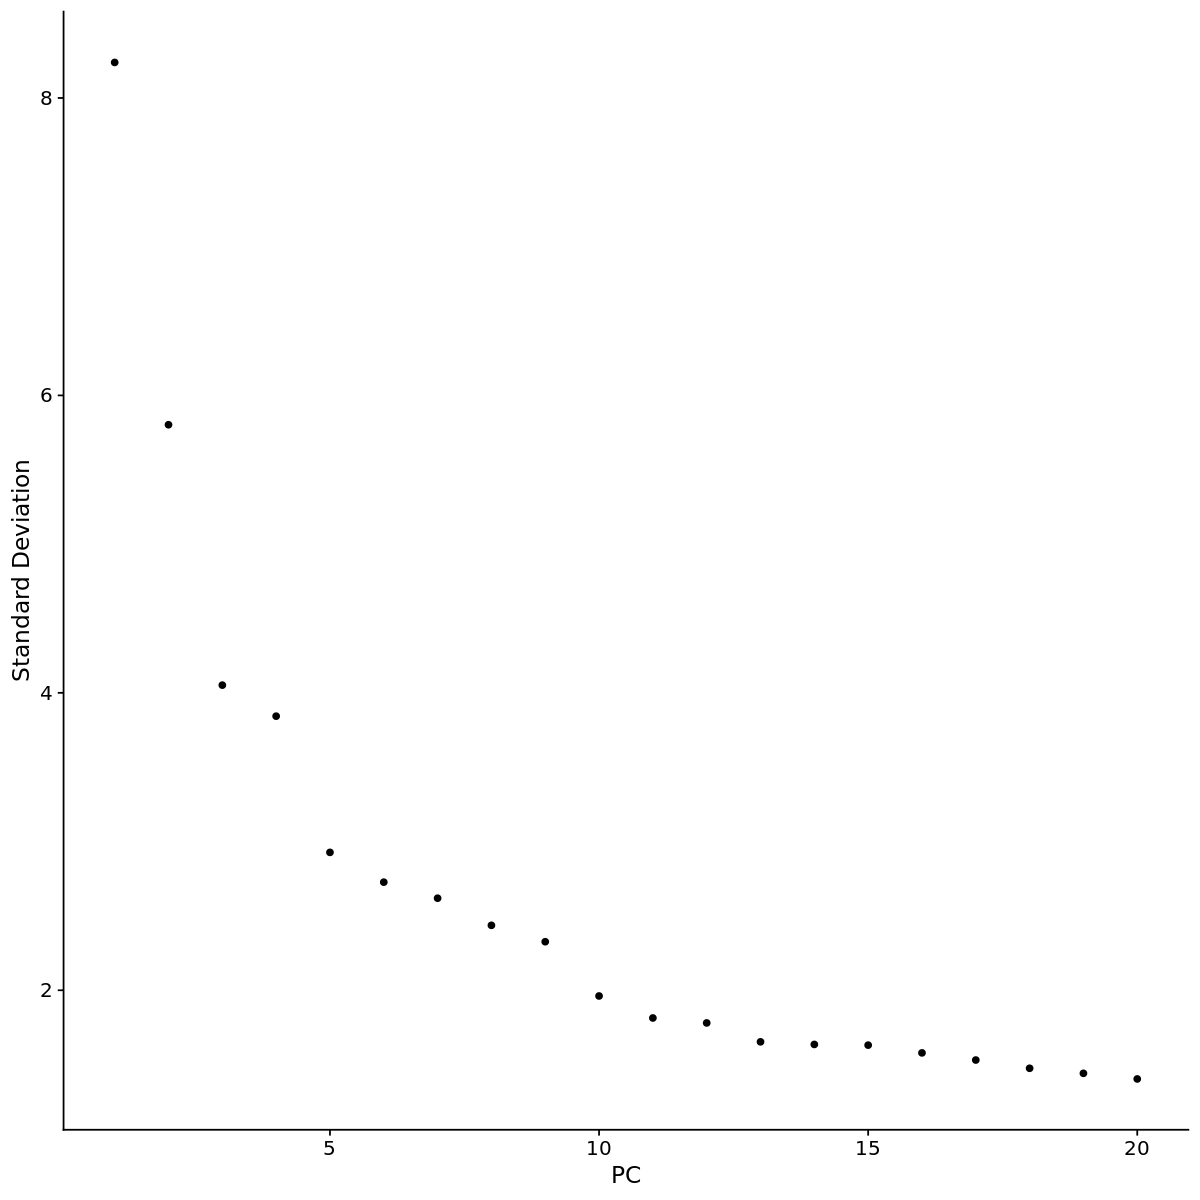

In [34]:
ElbowPlot(data)

In [35]:
data

An object of class Seurat 
25814 features across 5073 samples within 3 assays 
Active assay: AUC (411 features, 200 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: RNA, HTO
 3 dimensional reductions calculated: pca, umap, umap_grn

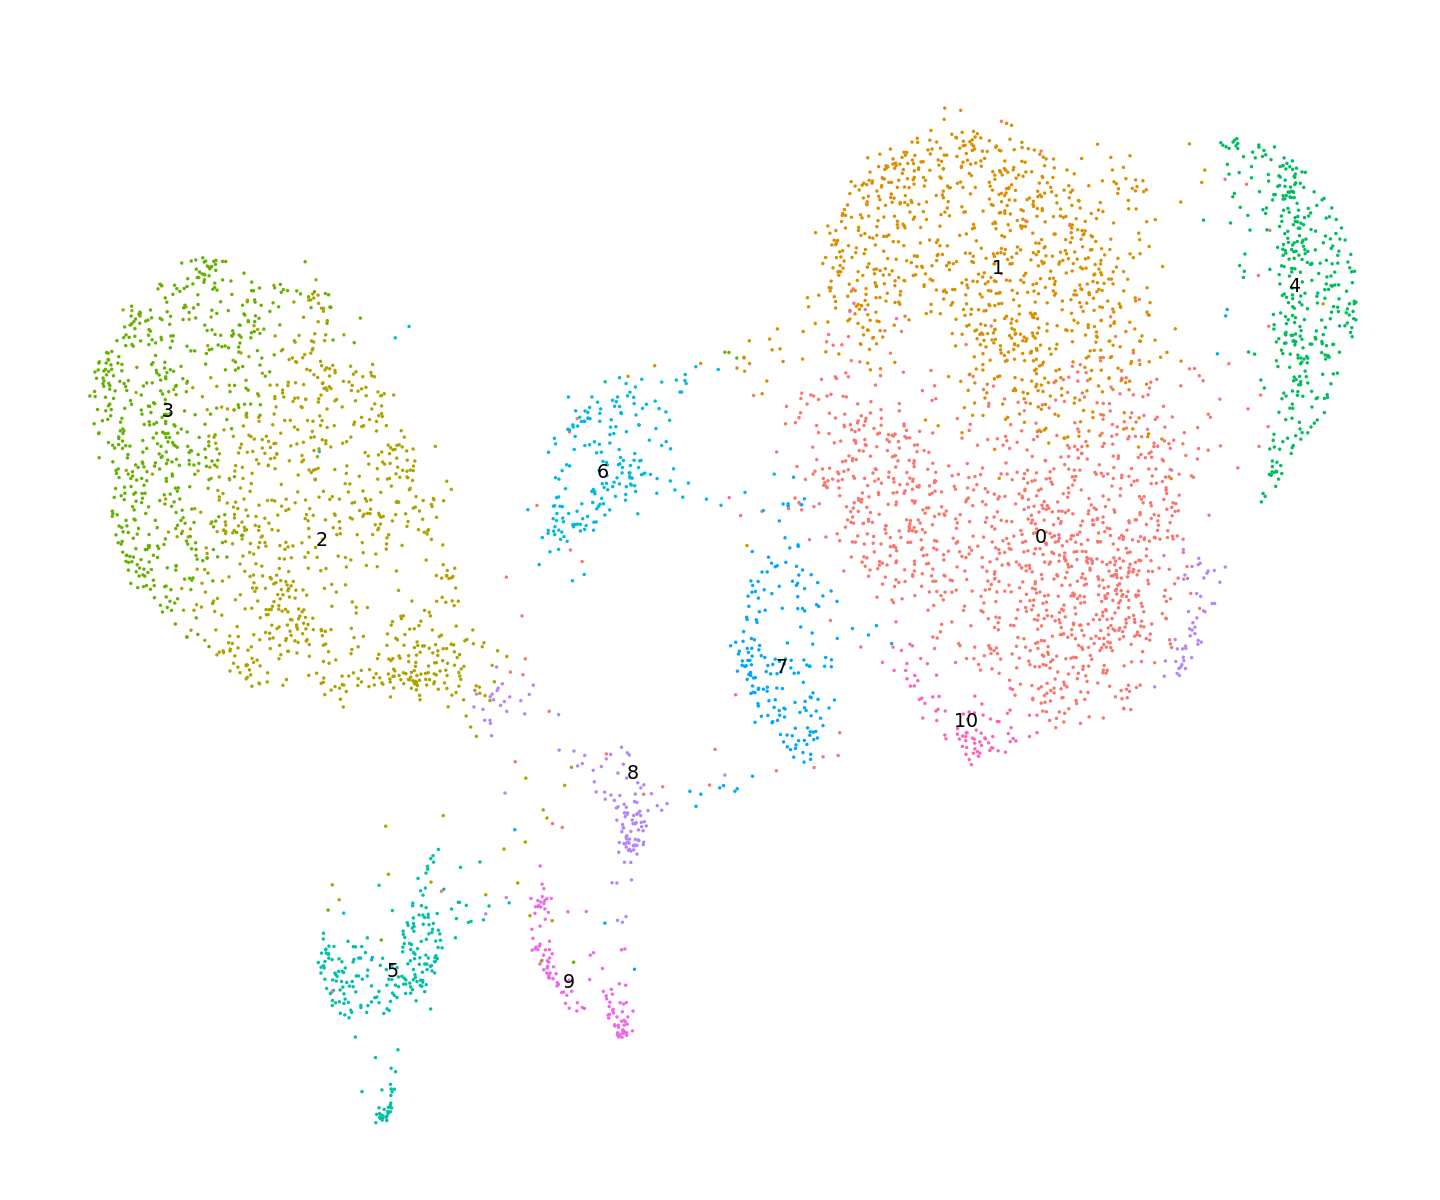

In [36]:
options(repr.plot.width = 12, repr.plot.height = 10)
DimPlot(data, reduction = "umap_grn", group.by = "GRN_clusters", label = TRUE) + NoAxes() + ggtitle("") + NoLegend()

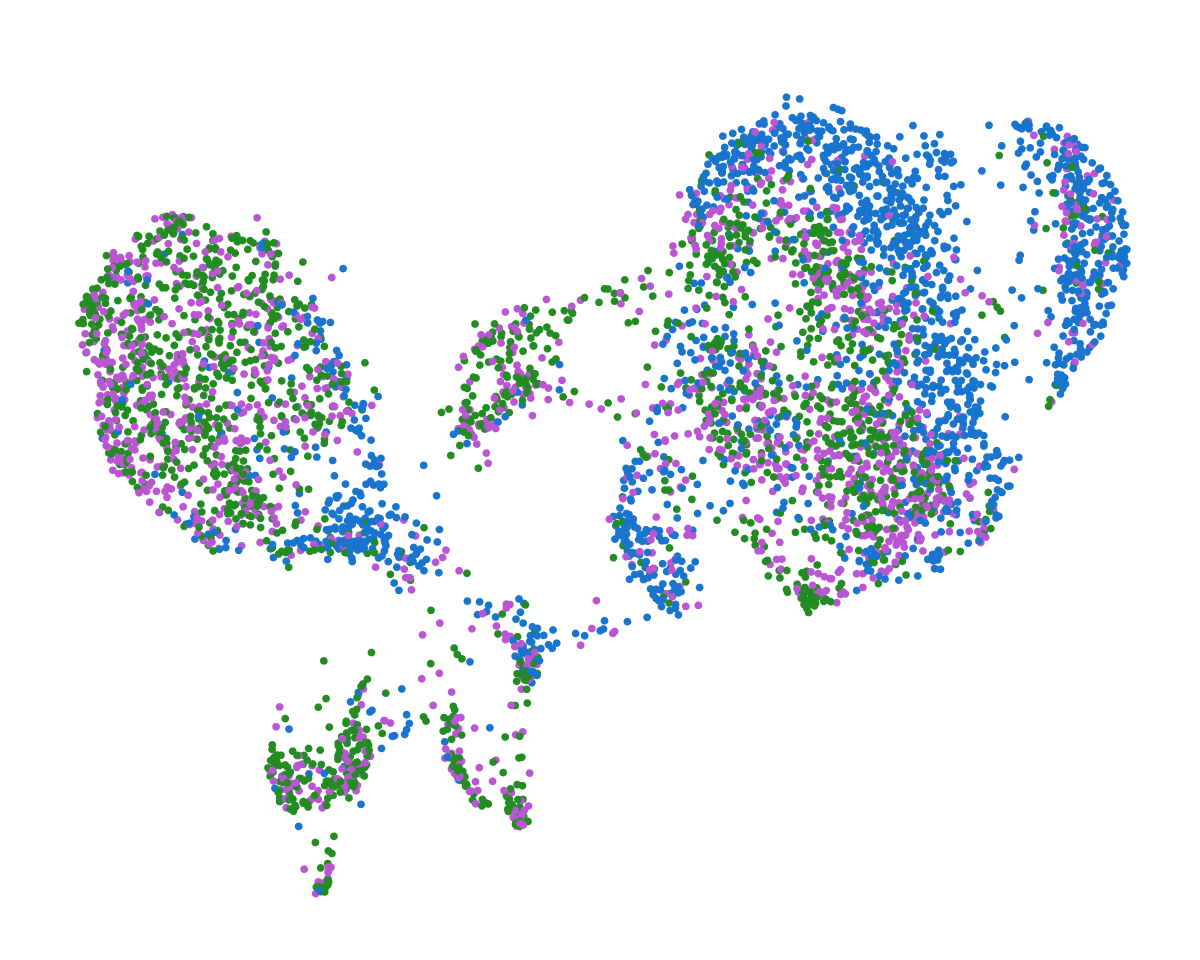

In [37]:
options(repr.plot.width = 10, repr.plot.height = 8)
DimPlot(data, reduction="umap_grn", group.by = "HTO_maxID", label = FALSE, 
        cols=c("MES"="forestgreen","PRO"="mediumorchid","WT"="dodgerblue3"), pt.size=1.5) + NoAxes() + ggtitle("") + NoLegend()

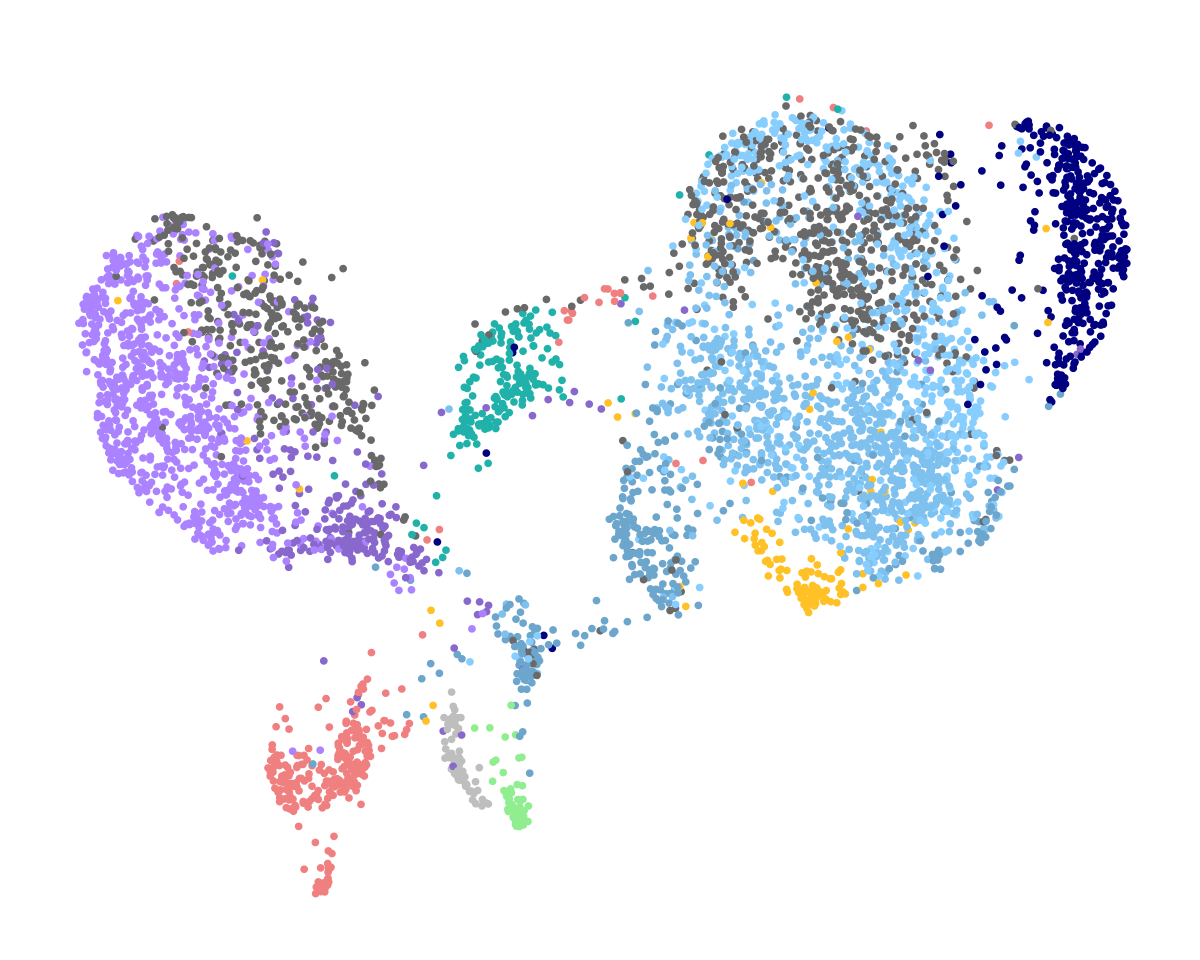

In [38]:
options(repr.plot.width = 10, repr.plot.height = 8)
DimPlot(data, reduction="umap_grn", group.by = "celltype2", label = FALSE, 
        cols=c("Mesenchyme-1"="mediumpurple1","RGC-2"="skyblue2","Proliferating"="dimgray","Neuronal"="navyblue","RGC-1"="skyblue1",
              "Proliferating"="dimgray","RGC-3"="skyblue3","Neuroepithelial"="lightcoral","Mesenchyme-2"="mediumpurple3",
              "RGC-1"="skyblue1","NeuralCrest"="lightseagreen","Retinal"="goldenrod1","RGC-2"="skyblue2",
              "RGC-3"="skyblue3","Endothelial"="gray","Microglia"="lightgreen"), pt.size=1.5) + NoAxes() + ggtitle("") + NoLegend()

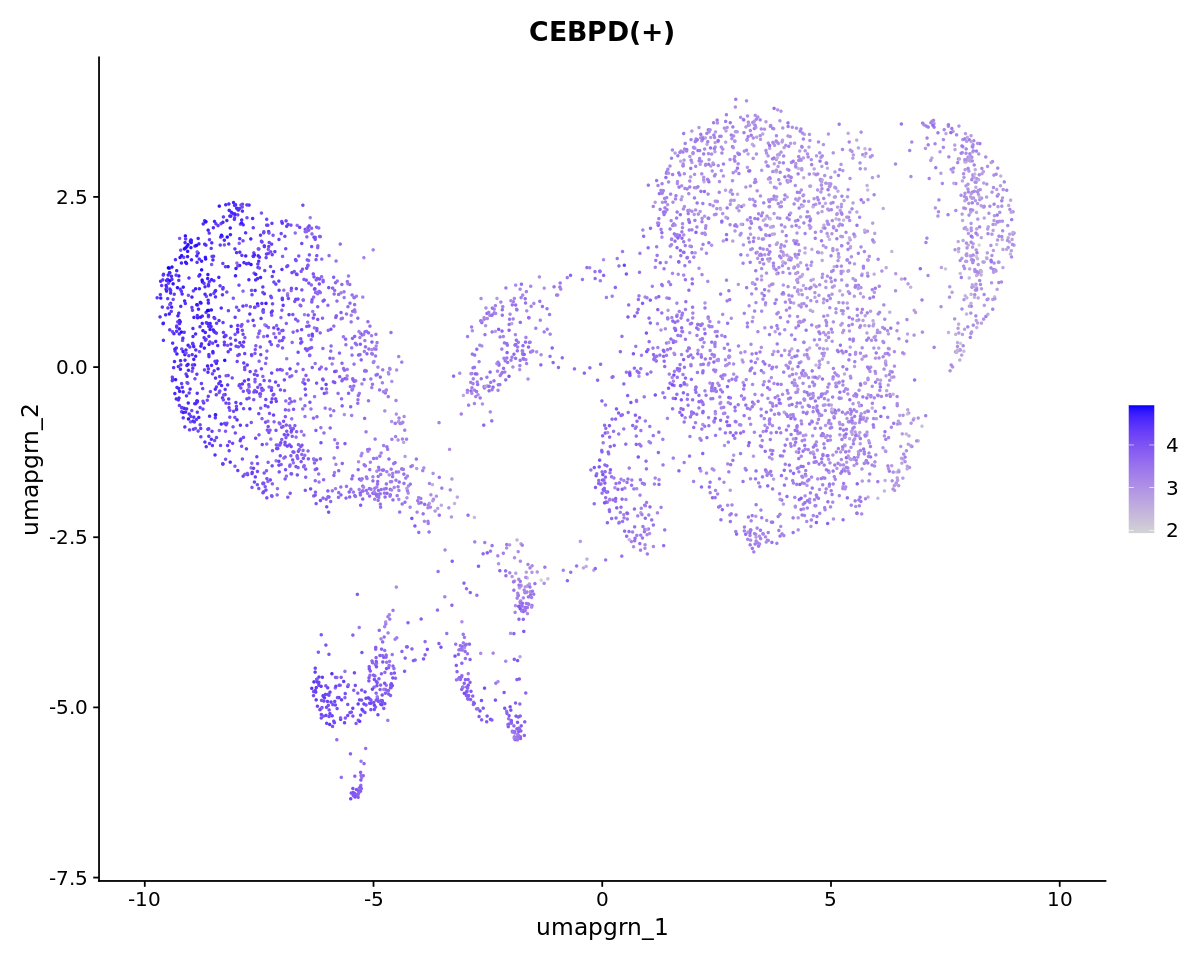

In [41]:
FeaturePlot(data, reduction = "umap_grn", features="CEBPD(+)")

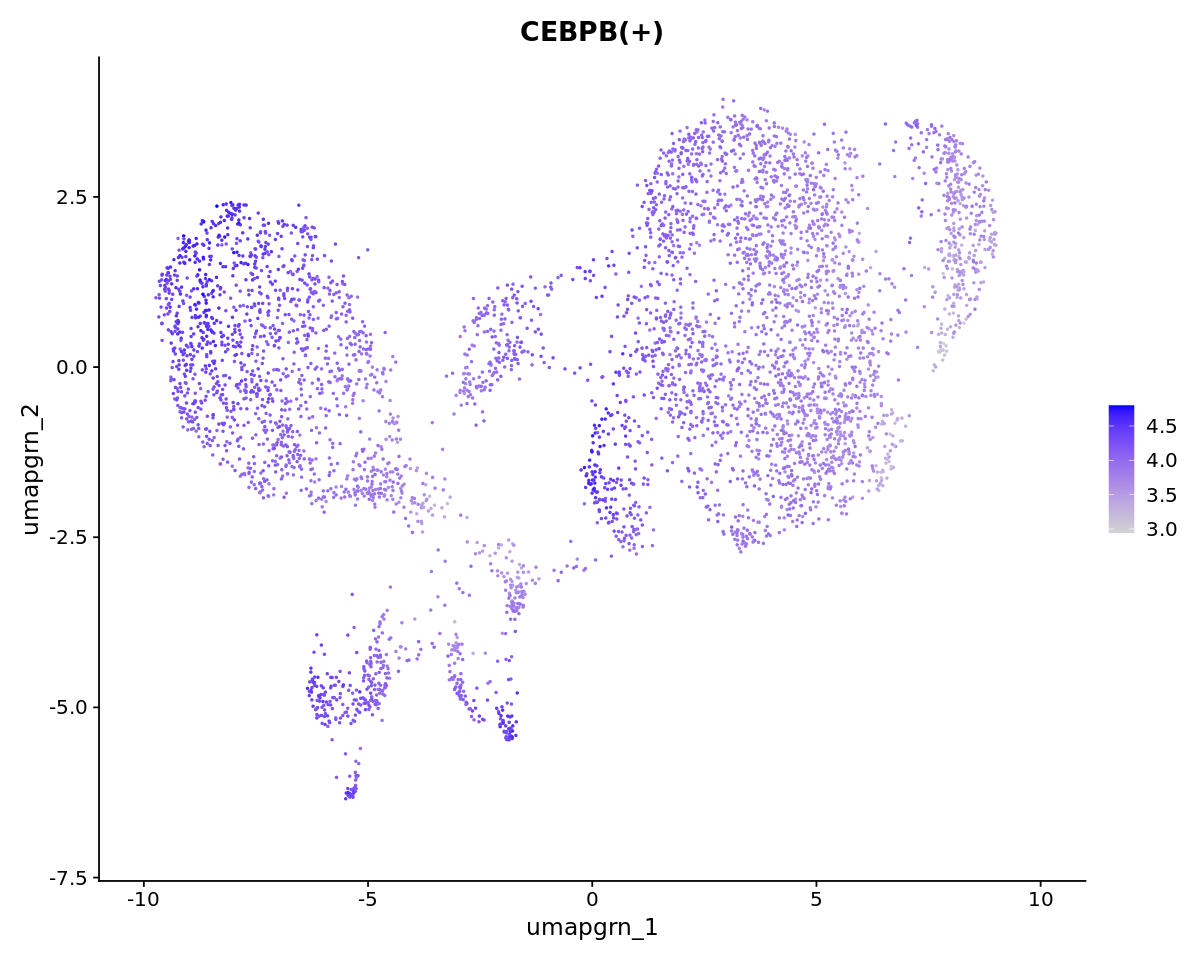

In [39]:
FeaturePlot(data, reduction = "umap_grn", features="CEBPB(+)")

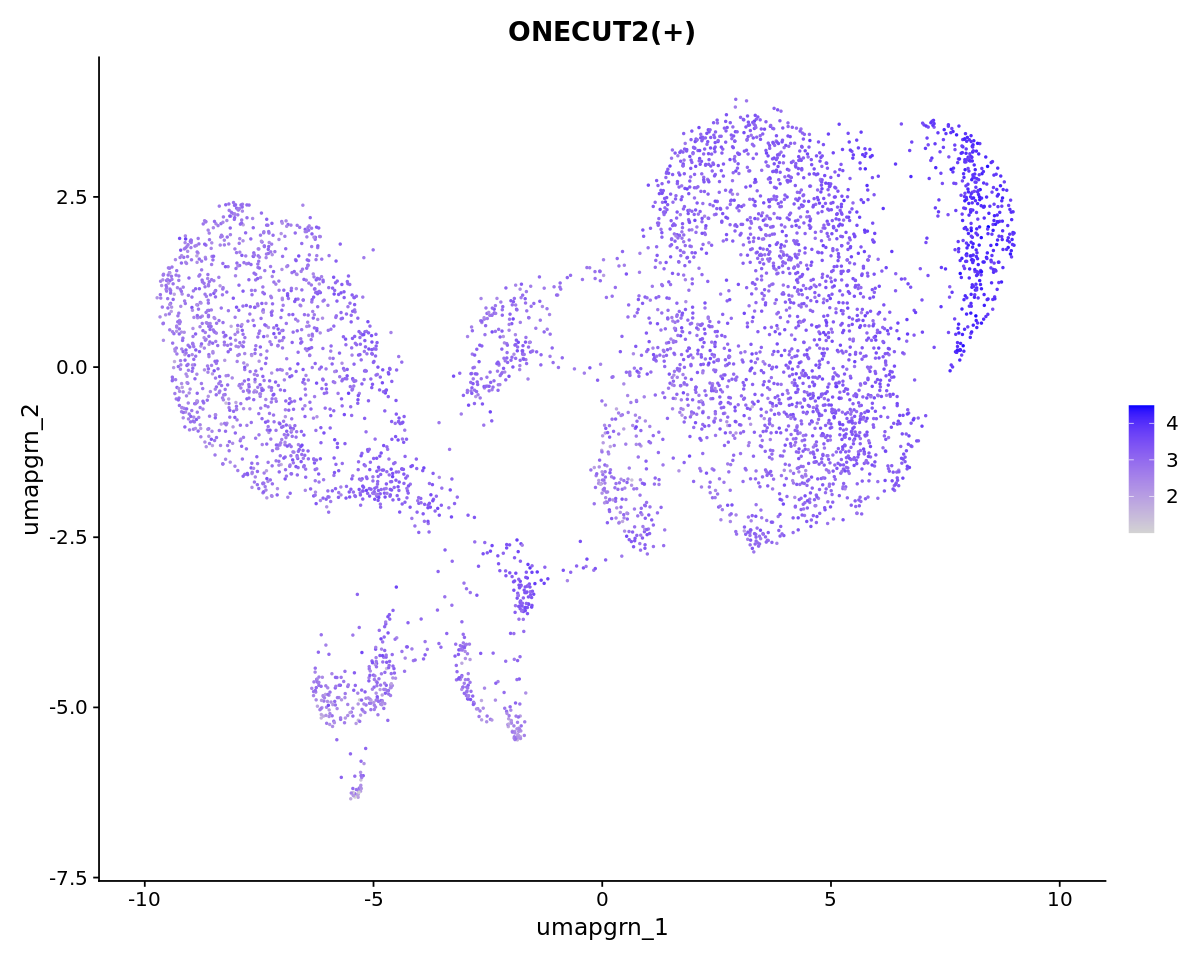

In [40]:
FeaturePlot(data, reduction = "umap_grn", features="ONECUT2(+)")

In [49]:
Idents(data) = "celltype"
GRN.celltype.markers <- FindAllMarkers(data, assay="AUC", only.pos=TRUE)

Calculating cluster Mesenchyme

Calculating cluster Radial Glia

Calculating cluster Proliferating

Calculating cluster Neuronal

Calculating cluster Neuroepithelial

Calculating cluster Neural Crest

Calculating cluster Retina Progenitor

Calculating cluster Endothelial

Calculating cluster Microglia



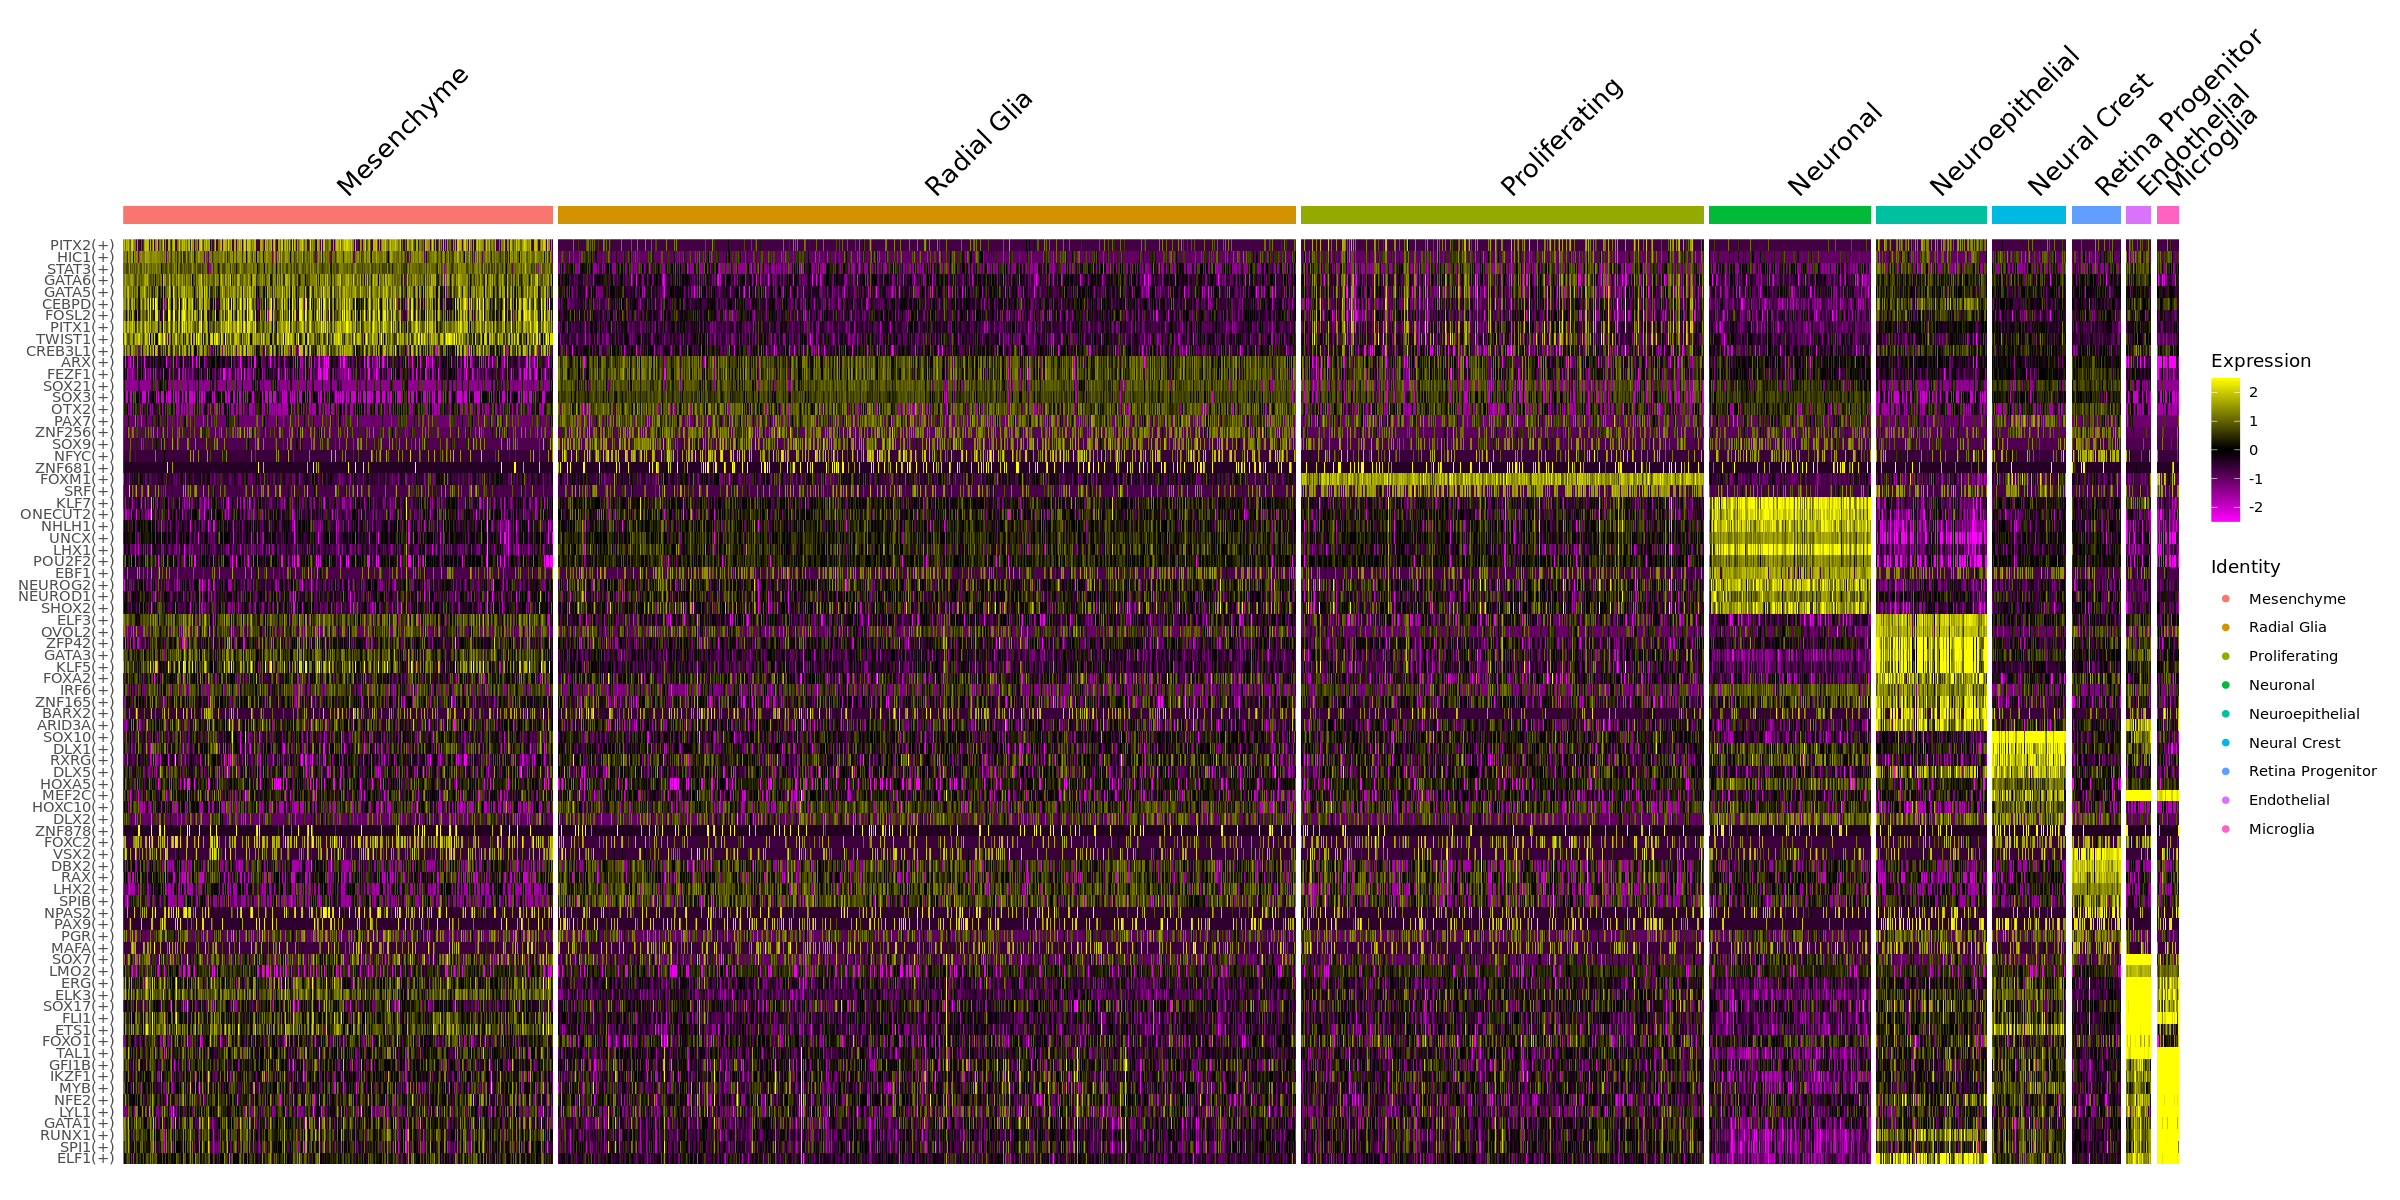

In [51]:
GRN.celltype.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10

options(repr.plot.width = 20, repr.plot.height = 10)
DoHeatmap(data, features = top10$gene)

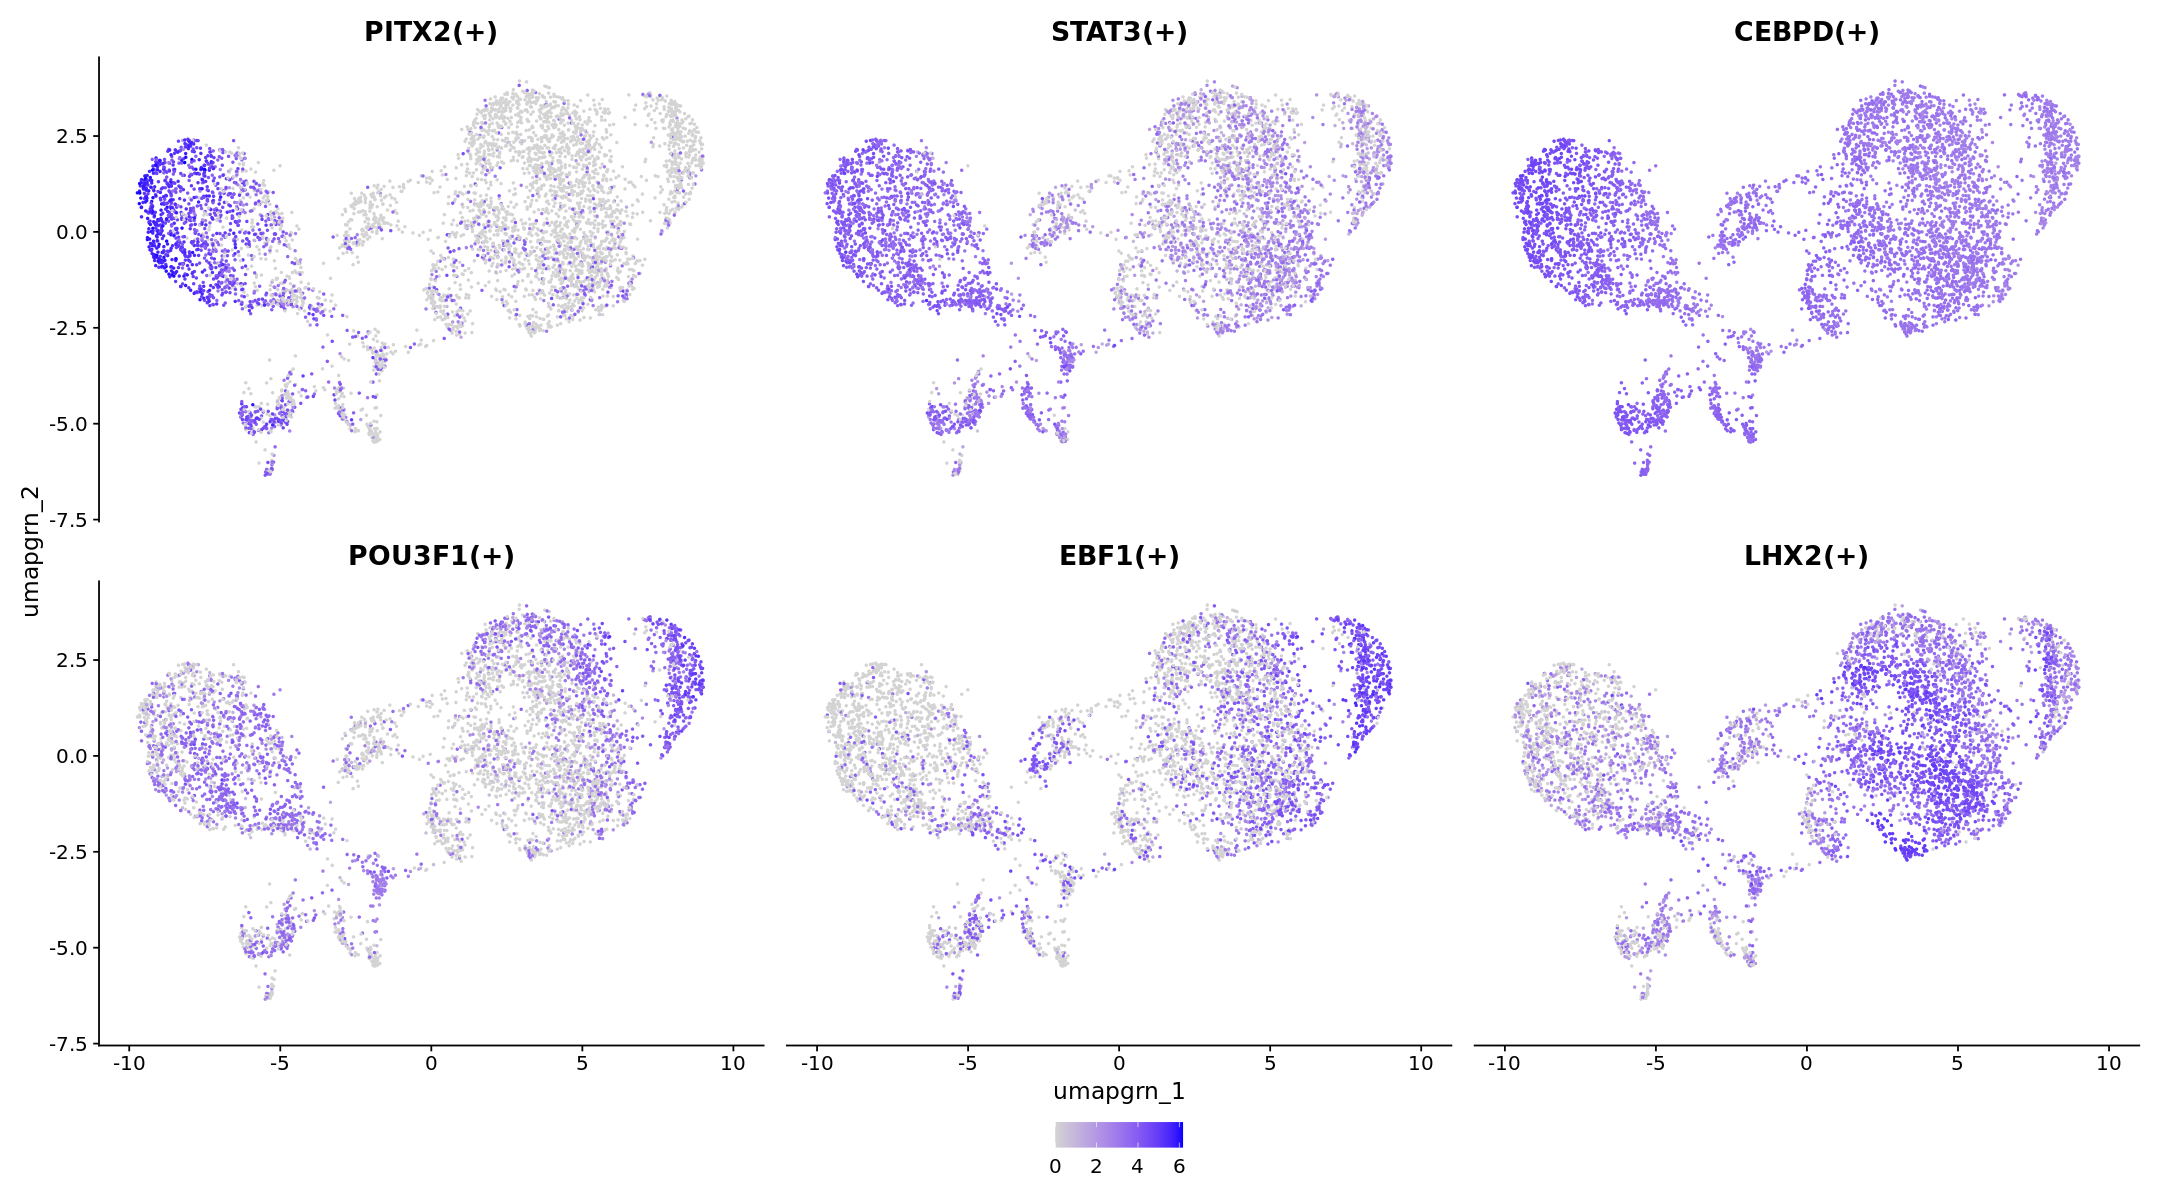

In [48]:
library(patchwork)
genes = c("PITX2(+)","STAT3(+)","CEBPD(+)","POU3F1(+)","EBF1(+)","LHX2(+)")

options(repr.plot.width = 18, repr.plot.height = 10)
FeaturePlot(data, reduction = "umap_grn", features = genes,ncol = 3, keep.scale="all") + plot_layout(axes = "collect", axis_titles = "collect", guides="collect") &
  theme(legend.position='bottom')